# Summary Stats for New Genes and Transcripts

### 1) Number of exons for novel genes and transcripts across stringency thresholds.

### 2) Exonic length for transcripts coming from novel RNA isoforms in known genes and novel RNA isoforms in new genes.

### 3) Number of new transcripts and genes with new transcripts for both new RNA isoforms in known genes and new genes.

### 4) Quantification of events giving origin to new isoforms in annotated transcripts. 

### 5) Wordcloud for protein coding and medically relvant transcripts.

### 6) General quantification of all transcripts.

### 7) Quantification of Novel transcripts.

### 8) Quantification of Protein Coding .
        - 8A) Protein Coding Genes.
        - 8B) Protein Coding Transcripts.
        - 8C) Protein Coding Transcripts Encoding Different Proteins.

### 9) Quantification of transcript found between Ensembl Release 94 and 107.

### 10) Quantification of medically relevant and AD relevant genes.

# Library Import and Functions

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud


## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
name: relative_transcript_abundance

purpose: calculate relative transcript abundance

input: a dataframe with a ref_gene_id column identifying the transcript gene of origin and a cov columns with 
the coverage for the transcripts.

output: the same dataframe with a relative abundance column added
'''



def relative_transcript_abundance(df):
    
    df_sums = df[["gene_id", "total_CPM"]].groupby("gene_id").sum()
    
    df_sums["total_CPM_gene"] = df_sums["total_CPM"]

    df_sums.drop(columns="total_CPM", inplace=True)
    
    merged_df = pd.merge(df, df_sums, how='inner', on="gene_id")
    
    merged_df["relative_abundance_percent"] = ((merged_df["total_CPM"]/merged_df["total_CPM_gene"]) * 100)
    
    merged_df["total_CPM_transcript"] = merged_df["total_CPM"]
    
    merged_df.drop(columns="total_CPM", inplace=True)


    return merged_df

In [3]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = df.columns.tolist()
        list_new_names = ["gene_id"]
        
        ## gene_id comes in as index for gene counts data, make it into the first column instead
        df["gene_id"] = df.index
        cols = list(df.columns)
        cols = [cols[-1]] + cols[:-1]
        df = df[cols]
        df.reset_index(inplace=True, drop=True)
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = df.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_mapped")[0] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    df.columns = list_new_names
    
    return df 

In [4]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True, is_transcript=False, is_prot=False):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]
        
        ## Get get transcript biotype
        df["gene_biotype"] = df["other"].str.split('gene_biotype "', expand=True)[1].str.split('"', expand=True)[0]
        
        ## If is transcript get transcript id and transcript biotype
        if is_transcript:
            df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]
            df["transcript_biotype"] = df["other"].str.split('transcript_biotype "', expand=True)[1].str.split('"', expand=True)[0]
            
            ## If is prot get protein_id
            if is_prot:
                df["protein_id"] = df["other"].str.split('protein_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["ccds_id"] = df["other"].str.split('ccds_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)
        

    else:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [5]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):

    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = df.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = df.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in count_columns:
        
        df[col] = round(df[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        df[cpm_name] = round(((df[col]/(df[col].sum())) * 1000000), 2)
    
    return df  

In [6]:
## define ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

# 1) Number of exons for novel genes and transcripts across stringency thresholds.

In [7]:
## Fix column names in counts matrix

df = pd.read_csv("../../../data/bernardo/raw/uky_aged_stringent/bambu_discovery/counts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

df = fix_column_names(df, is_gene=False)

In [8]:
## Calculate total counts and fix gene id
df["total_counts"] = df[(df.filter(regex='counts')).columns].sum(axis=1)

In [9]:
## Calculate CPM and drop count columns
df = calculate_cpm(df, is_gene=False)

df = df[df.columns.drop(list(df.filter(regex='counts')))]

In [10]:
## Calculate median CPM
df["median_CPM"] = df[(df.filter(regex='e_CPM')).columns].median(axis=1)

In [11]:
## Create dataframes with either only novel genes or only novel transcripts that are not from novel genes
df_novel_genes = df.loc[df["gene_id"].str.startswith("BambuGene")].copy()
df_novel_transcripts = df.loc[((df["transcript_id"].str.startswith("BambuTx")) & (~df["gene_id"].str.startswith("BambuGene")))].copy()

In [12]:
## Filter novel genes and transcripts, one only total CPM > 1, other each CPM > 1
cpm_cols = (df.filter(regex='e_CPM')).columns.to_list()

df_novel_genes_median = df_novel_genes[df_novel_genes["median_CPM"] > 1].copy()
df_novel_transcripts_median = df_novel_transcripts[df_novel_transcripts["median_CPM"] > 1].copy()

In [13]:
## Import and parse through extended annotations
ref = pd.read_csv("../../../data/bernardo/raw/uky_aged_stringent/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])


ref = parse_df_columns(ref, is_ref=False)

In [14]:
## Only keep exon entries and add size variable
ref_exons = ref.loc[ref["type"] == "exon"].copy()
ref_exons["size"] = abs(ref_exons["end"] - ref_exons["start"])

In [15]:
## Get reference for novel genes and transcripts at each threshold
ref_novel_gene_median = ref_exons.loc[ref_exons["transcript_id"].isin(df_novel_genes_median["transcript_id"])].copy()
ref_novel_transcript_median = ref_exons.loc[ref_exons["transcript_id"].isin(df_novel_transcripts_median["transcript_id"])].copy()

ref_novel_gene = ref_exons.loc[ref_exons["gene_id"].str.startswith("BambuGene")].copy()
ref_novel_transcript = ref_exons.loc[((ref_exons["transcript_id"].str.startswith("BambuTx")) & 
                                      (~ref_exons["gene_id"].str.startswith("BambuGene")))].copy()

In [16]:
## get number of exons for each threshold
ref_novel_gene_median_num_exons = ref_novel_gene_median["transcript_id"].value_counts()
ref_novel_transcript_median_num_exons = ref_novel_transcript_median["transcript_id"].value_counts()


ref_novel_gene_num_exons = ref_novel_gene["transcript_id"].value_counts()
ref_novel_transcript_num_exons = ref_novel_transcript["transcript_id"].value_counts()

In [17]:
## Set parameters for figures
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 12,8
rcParams.update({'font.size': 24})
rcParams['axes.linewidth'] = 6

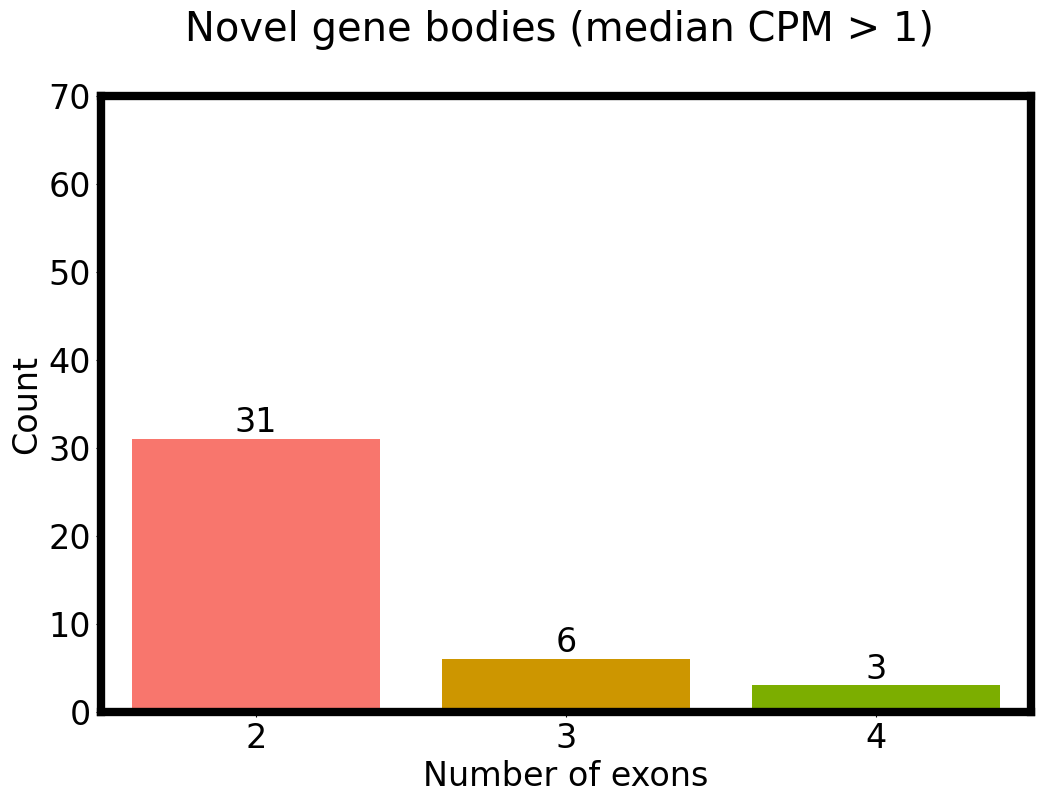

In [18]:
## Make median CPM > 1 gene body number of exons plot and save both as png and svg.

ax = sns.countplot(x=ref_novel_gene_median_num_exons, palette=ggplot2_colors, saturation=1)
    
for container in ax.containers:
    ax.bar_label(container)

ax.set_ylim(0, 70)

plt.xlabel("Number of exons")
plt.ylabel("Count")
plt.title("Novel gene bodies (median CPM > 1) \n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/01/novel_gene_bodies_median_cpm_exon_number.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/01/novel_gene_bodies_median_cpm_exon_number.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

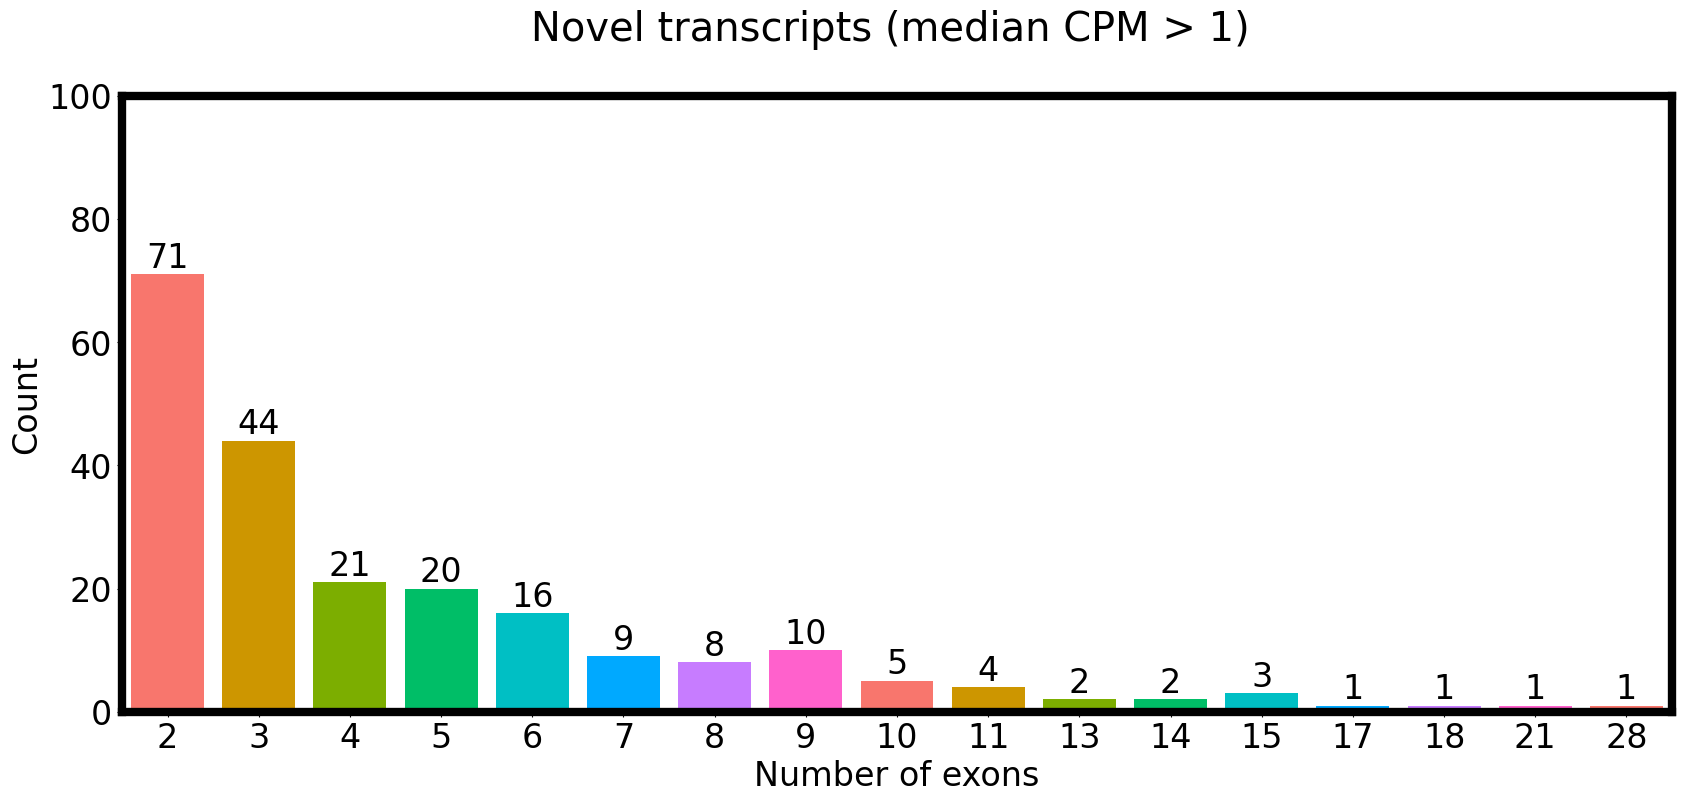

In [19]:
## Make median CPM > 1 transcript number of exons plot and save both as png and svg.

# figure size in inches
rcParams['figure.figsize'] = 20,8
rcParams.update({'font.size': 24})
rcParams['axes.linewidth'] = 6

ax = sns.countplot(x=ref_novel_transcript_median_num_exons, palette=ggplot2_colors, saturation=1)

for container in ax.containers:
    ax.bar_label(container)

ax.set_ylim(0, 100)

plt.xlabel("Number of exons")
plt.ylabel("Count")
plt.title("Novel transcripts (median CPM > 1) \n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/01/novel_transcripts_median_cpm_exon_number.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/01/novel_transcripts_median_cpm_exon_number.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

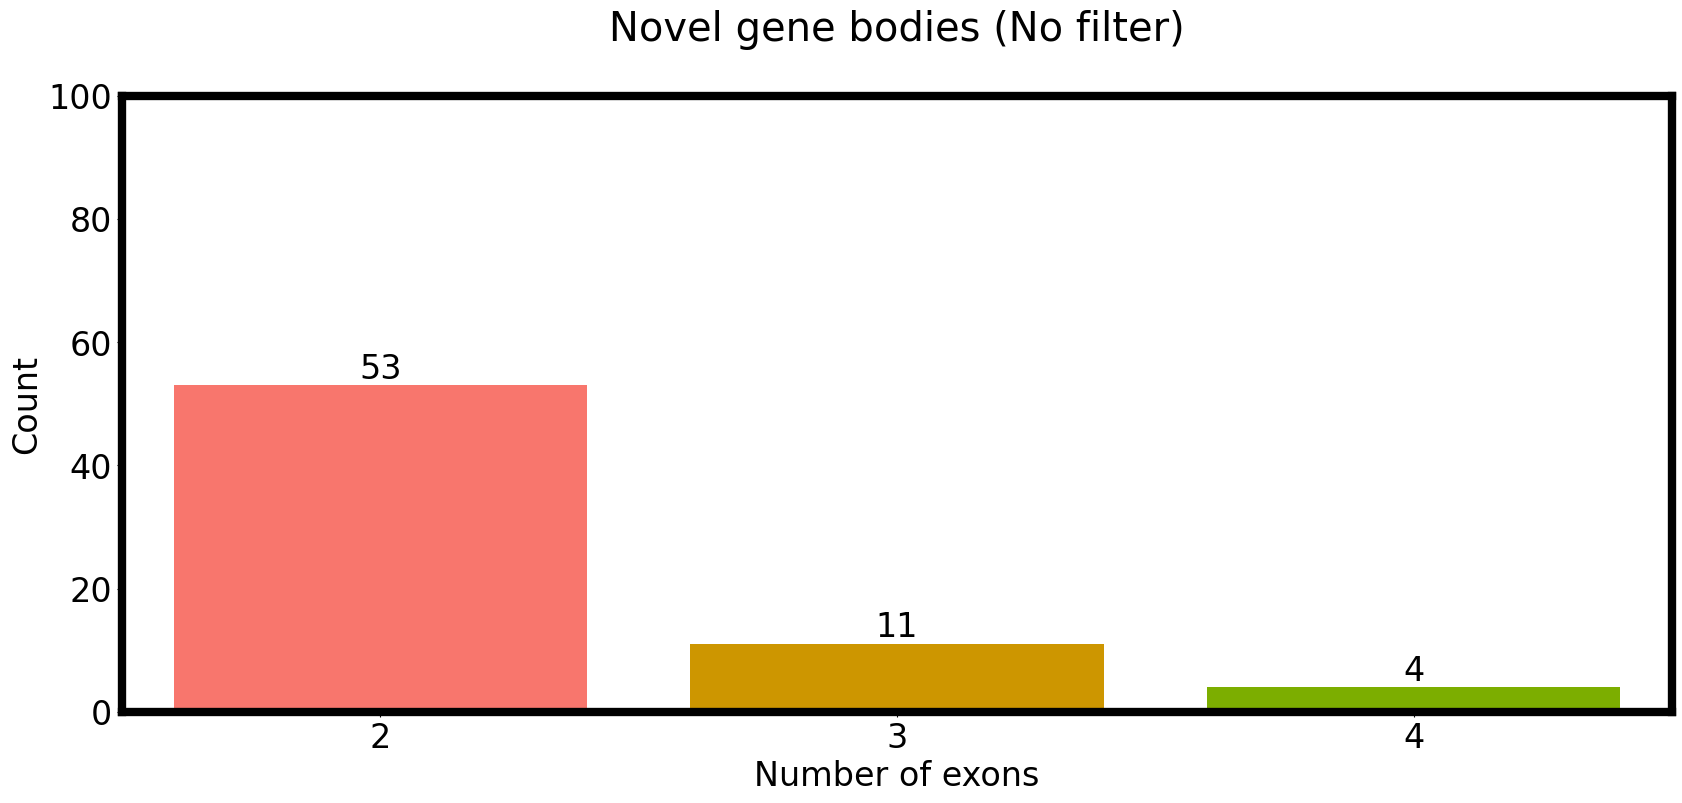

In [20]:
## Make no filter gene body number of exons plot and save both as png and svg.

ax = sns.countplot(x=ref_novel_gene_num_exons, palette=ggplot2_colors, saturation=1)

for container in ax.containers:
    ax.bar_label(container)

ax.set_ylim(0, 100)


plt.xlabel("Number of exons")
plt.ylabel("Count")
plt.title("Novel gene bodies (No filter)\n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/01/novel_gene_bodies_no_filter_cpm_exon_number.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/01/novel_gene_bodies_no_filter_cpm_exon_number.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

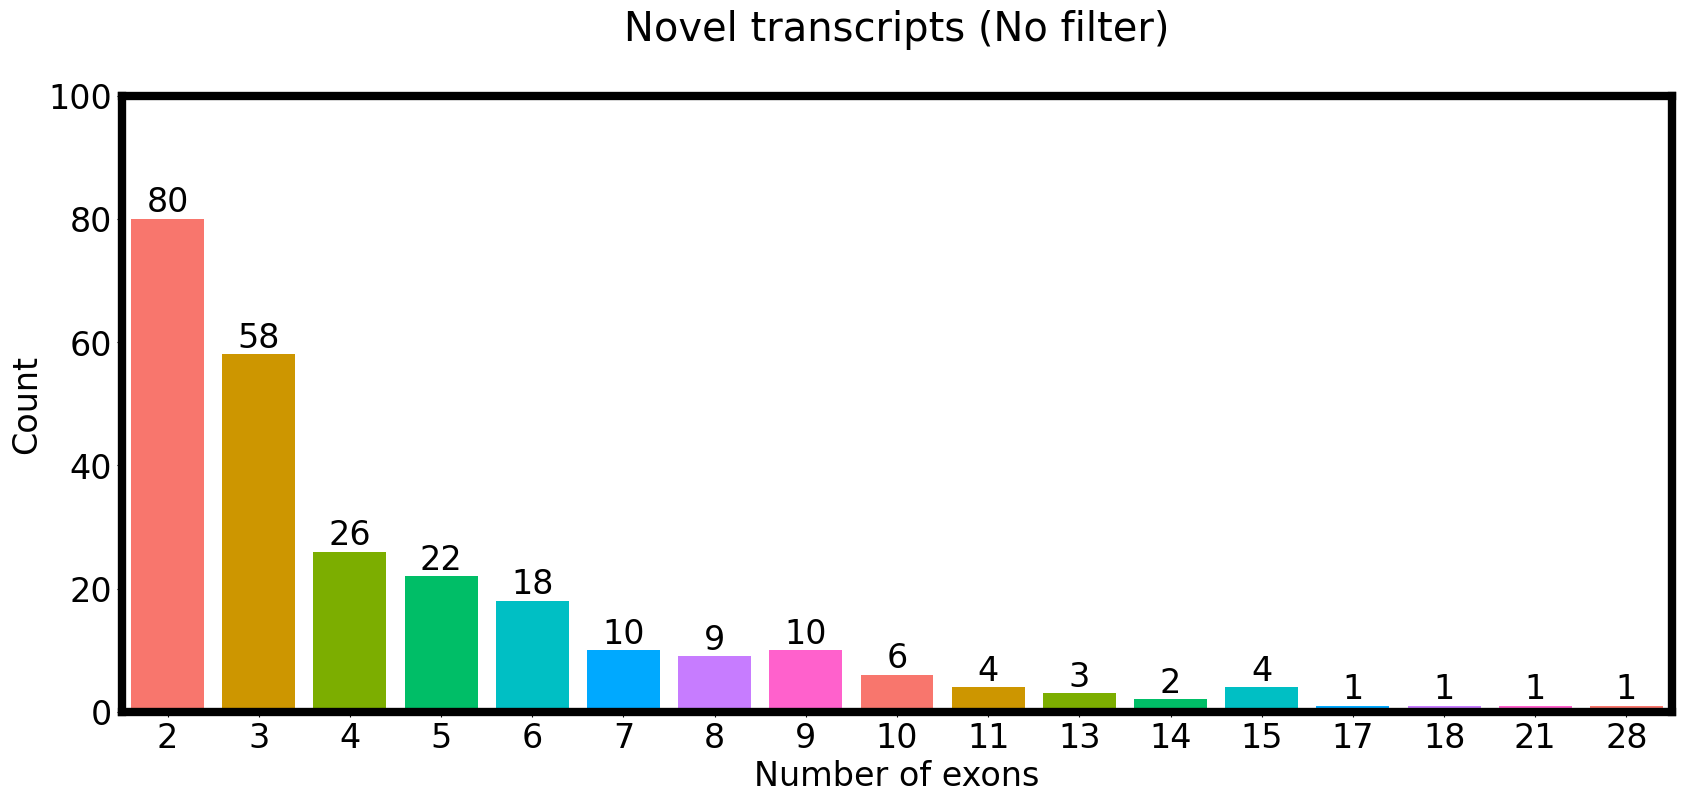

In [21]:
## Make no filter transcript number of exons plot and save both as png and svg.

rcParams['figure.figsize'] = 20,8

ax = sns.countplot(x=ref_novel_transcript_num_exons, palette=ggplot2_colors, saturation=1)

for container in ax.containers:
    ax.bar_label(container)
    
ax.set_ylim(0, 100)


plt.xlabel("Number of exons")
plt.ylabel("Count")
plt.title("Novel transcripts (No filter)\n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/01/novel_transcripts_no_filter_cpm_exon_number.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/01/novel_transcripts_no_filter_cpm_exon_number.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

# 2) Exonic length for transcripts coming from novel RNA isoforms in known genes and novel RNA isoforms in new genes

In [22]:
# figure size in inches
rcParams['figure.figsize'] = 12,8
rcParams.update({'font.size': 24})
rcParams['axes.linewidth'] = 6

In [23]:
## Create dataframes with exonic length for each transcript
df_exonic_length_novel_genes_median = ref_novel_gene_median[["transcript_id", "size"]].groupby('transcript_id').sum()
df_exonic_length_novel_transcripts_median = ref_novel_transcript_median[["transcript_id", "size"]].groupby('transcript_id').sum()

df_exonic_length_novel_genes = ref_novel_gene[["transcript_id", "size"]].groupby('transcript_id').sum()
df_exonic_length_novel_transcripts = ref_novel_transcript[["transcript_id", "size"]].groupby('transcript_id').sum()

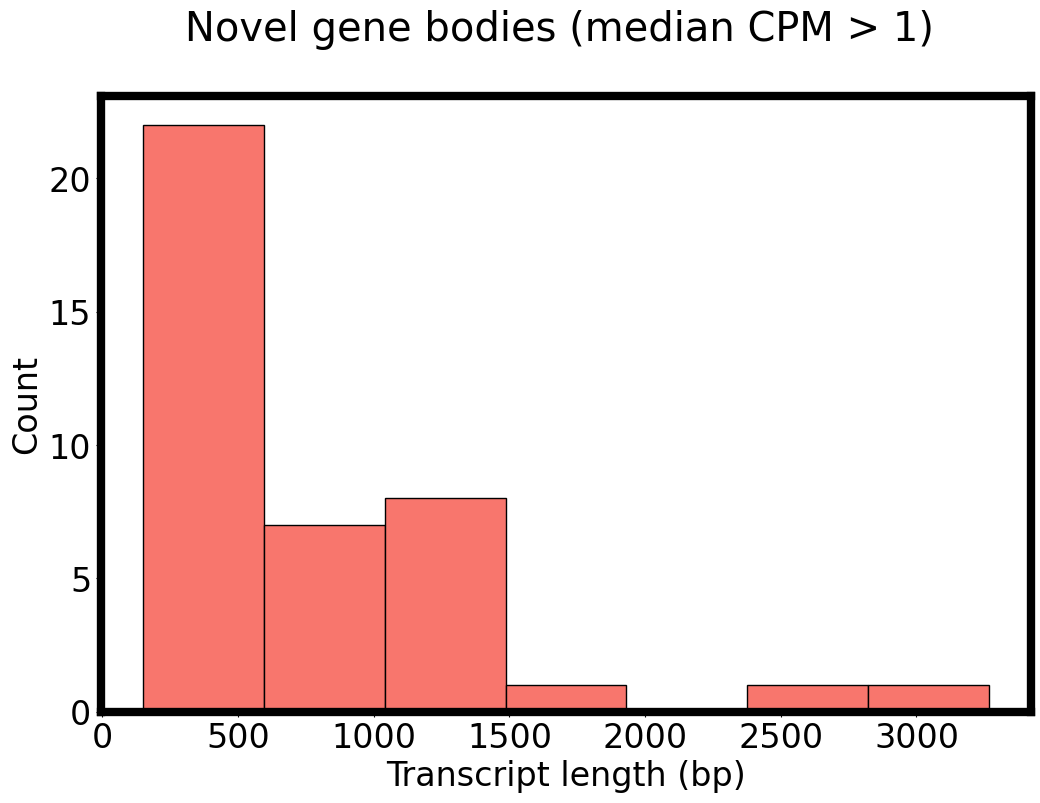

In [24]:
## Make median CPM > 1 gene body number of exons plot and save both as png and svg.

sns.histplot(x=df_exonic_length_novel_genes_median["size"], color=ggplot2_colors[0], alpha=1)
plt.xlabel("Transcript length (bp)")
plt.ylabel("Count")
plt.title("Novel gene bodies (median CPM > 1) \n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/02/histogram_novel_gene_bodies_median_cpm_length.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/02/histogram_nnovel_gene_bodies_median_cpm_length.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

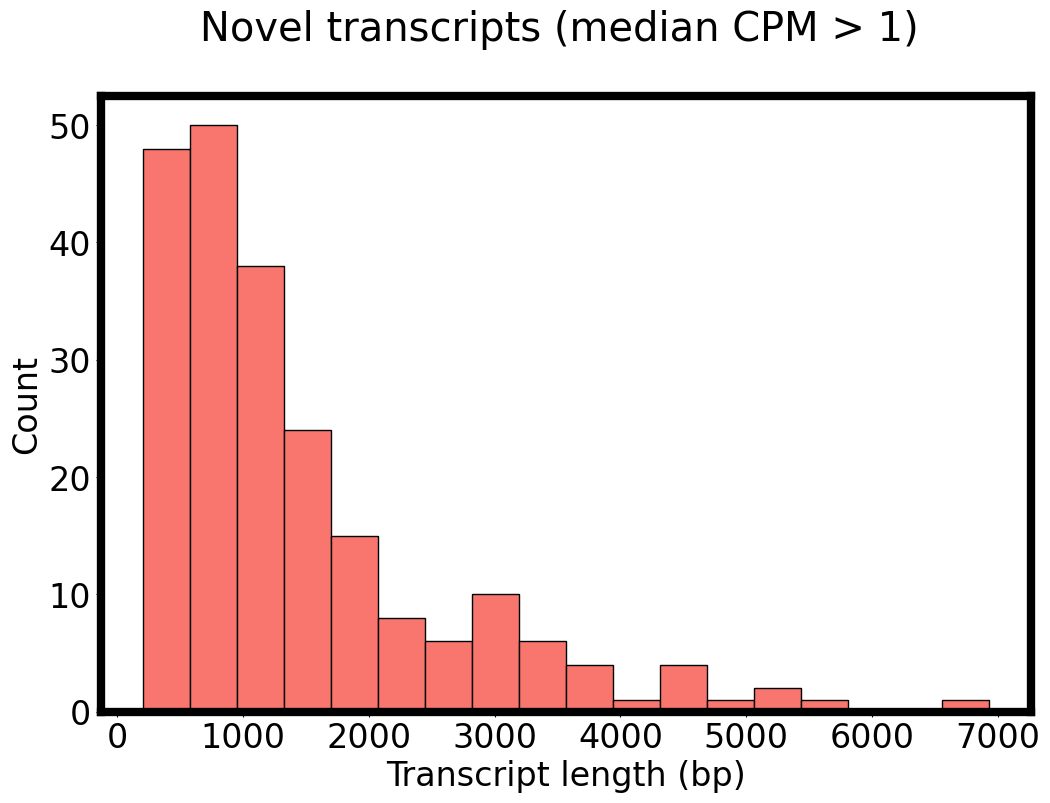

In [25]:
## Make median CPM > 1 gene body number of exons plot and save both as png and svg.

sns.histplot(x=df_exonic_length_novel_transcripts_median["size"], color=ggplot2_colors[0], alpha=1)
plt.xlabel("Transcript length (bp)")
plt.ylabel("Count")
plt.title("Novel transcripts (median CPM > 1) \n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/02/histogram_novel_transcripts_median_cpm_length.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/02/histogram_novel_transcripts_median_cpm_length.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

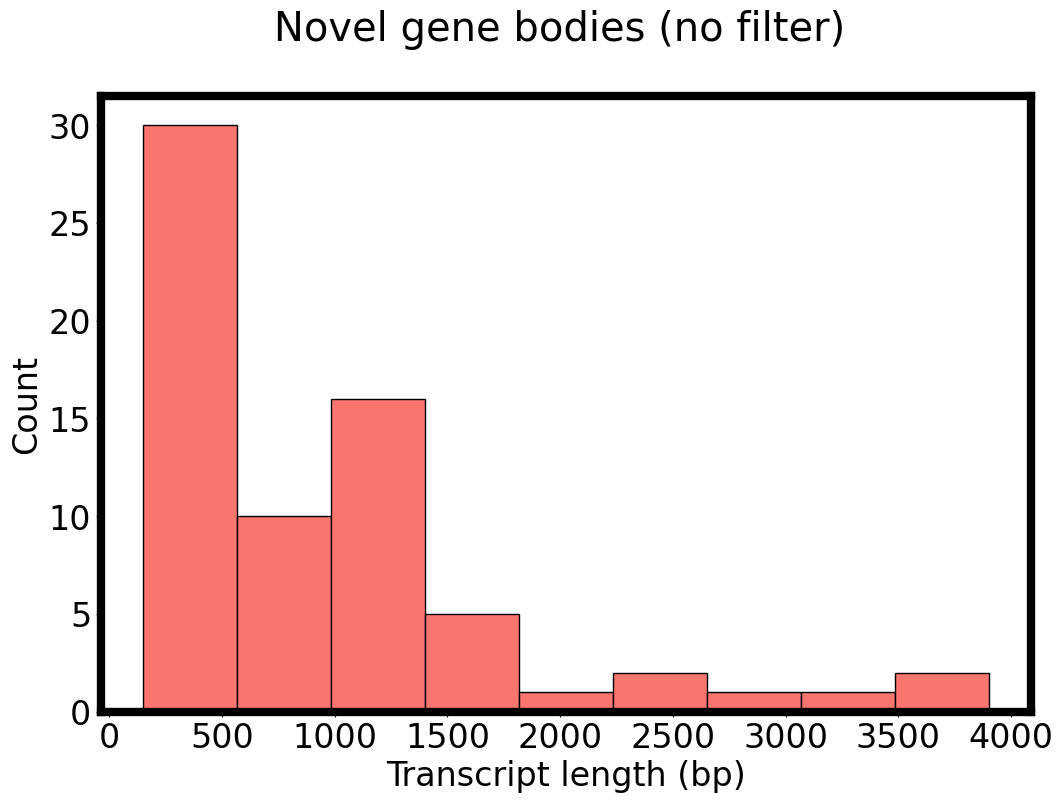

In [26]:
## Make no filter gene body number of exons plot and save both as png and svg.
sns.histplot(x=df_exonic_length_novel_genes["size"], color=ggplot2_colors[0], alpha=1)
plt.xlabel("Transcript length (bp)")
plt.ylabel("Count")
plt.title("Novel gene bodies (no filter) \n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/02/histogram_novel_gene_bodies_no_filter_length.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/02/histogram_novel_gene_bodies_no_filter_length.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

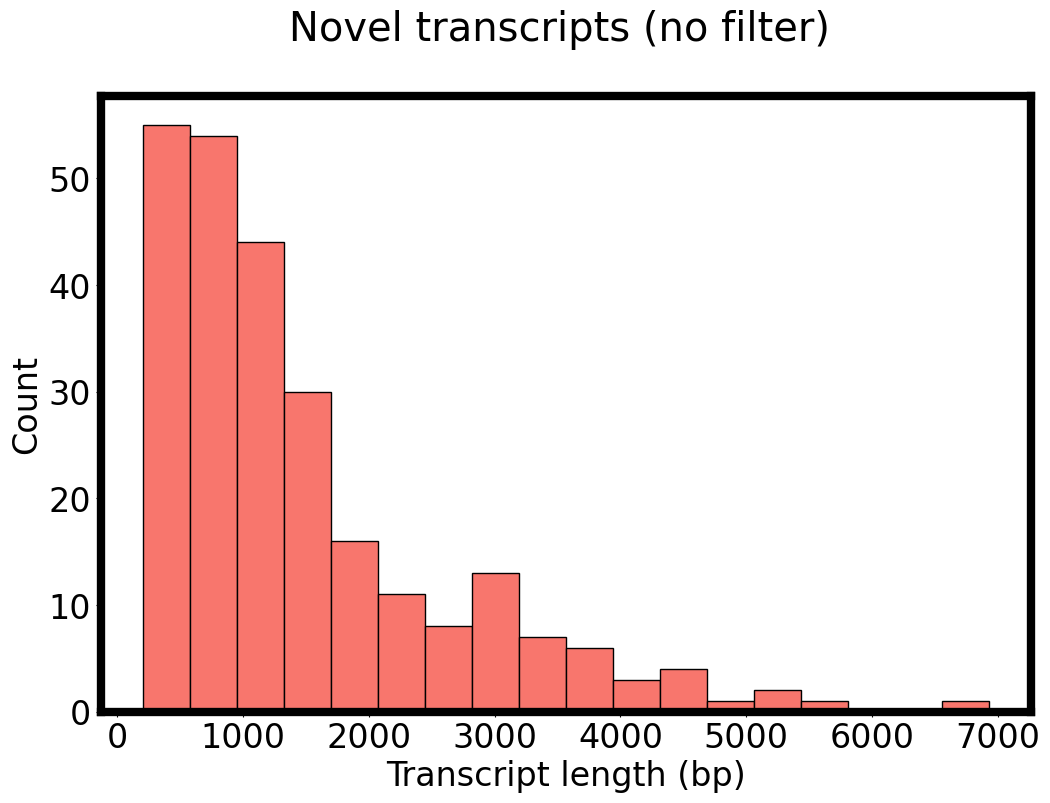

In [27]:
## Make median CPM > 1 gene body number of exons plot and save both as png and svg.

sns.histplot(x=df_exonic_length_novel_transcripts["size"], color=ggplot2_colors[0], alpha=1)
plt.xlabel("Transcript length (bp)")
plt.ylabel("Count")
plt.title("Novel transcripts (no filter) \n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/02/histogram_novel_transcripts_no_filter_length.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/02/histogram_novel_transcripts_no_filter_length.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

# 3) Number of new transcripts and genes with new transcripts for both new RNA isoforms in known genes and new genes

In [28]:
## Get number of transcripts from each filter from each filter

print("Number of transcripts mapping to novel genes (no filter):", df_novel_genes.shape[0])
print("Number of transcripts mapping to novel genes (median CPM > 1):", df_novel_genes_median.shape[0])

print("\n\nNumber of novel transcripts mapping to annotated genes (no filter):", df_novel_transcripts.shape[0])
print("Number of novel transcripts mapping to annotated genes (median CPM > 1):", df_novel_transcripts_median.shape[0])

Number of transcripts mapping to novel genes (no filter): 68
Number of transcripts mapping to novel genes (median CPM > 1): 40


Number of novel transcripts mapping to annotated genes (no filter): 256
Number of novel transcripts mapping to annotated genes (median CPM > 1): 219


In [29]:
## Get number of genes represented for each filter

print("Number of novel genes represented (no filter):", df_novel_genes["gene_id"].nunique())
print("Number of novel genes represented (median CPM > 1):", df_novel_genes_median["gene_id"].nunique())

print("\n\nNumber of represented annotated genes with novel transcripts (no filter):", df_novel_transcripts["gene_id"].nunique())
print("Number of represented annotated genes with novel transcripts (median CPM > 1):", df_novel_transcripts_median["gene_id"].nunique())

Number of novel genes represented (no filter): 63
Number of novel genes represented (median CPM > 1): 37


Number of represented annotated genes with novel transcripts (no filter): 243
Number of represented annotated genes with novel transcripts (median CPM > 1): 209


In [30]:
## Create dataframe for storing transcript numbers
df_num_genes = pd.DataFrame()

## Create list with unique transcripts and genes at each threshold
list_numbers = [df_novel_genes.shape[0], df_novel_genes["gene_id"].nunique(), df_novel_transcripts.shape[0], 
               df_novel_transcripts["gene_id"].nunique(),df_novel_genes_median.shape[0],
               df_novel_genes_median["gene_id"].nunique(), df_novel_transcripts_median.shape[0],
               df_novel_transcripts_median["gene_id"].nunique()]

list_filters = ["No Filter", "No Filter", "No Filter", "No Filter", "median CPM > 1", "median CPM > 1", "median CPM > 1", "median CPM > 1"]

list_labels = ["New Gene RNA Isoforms", "New Genes", "New RNA Isoforms from Annotated Genes", "Annotated Genes with New Isoforms", 
              "New Gene RNA Isoforms", "New Genes", "New RNA Isoforms from Annotated Genes", "Annotated Genes with New Isoforms"]

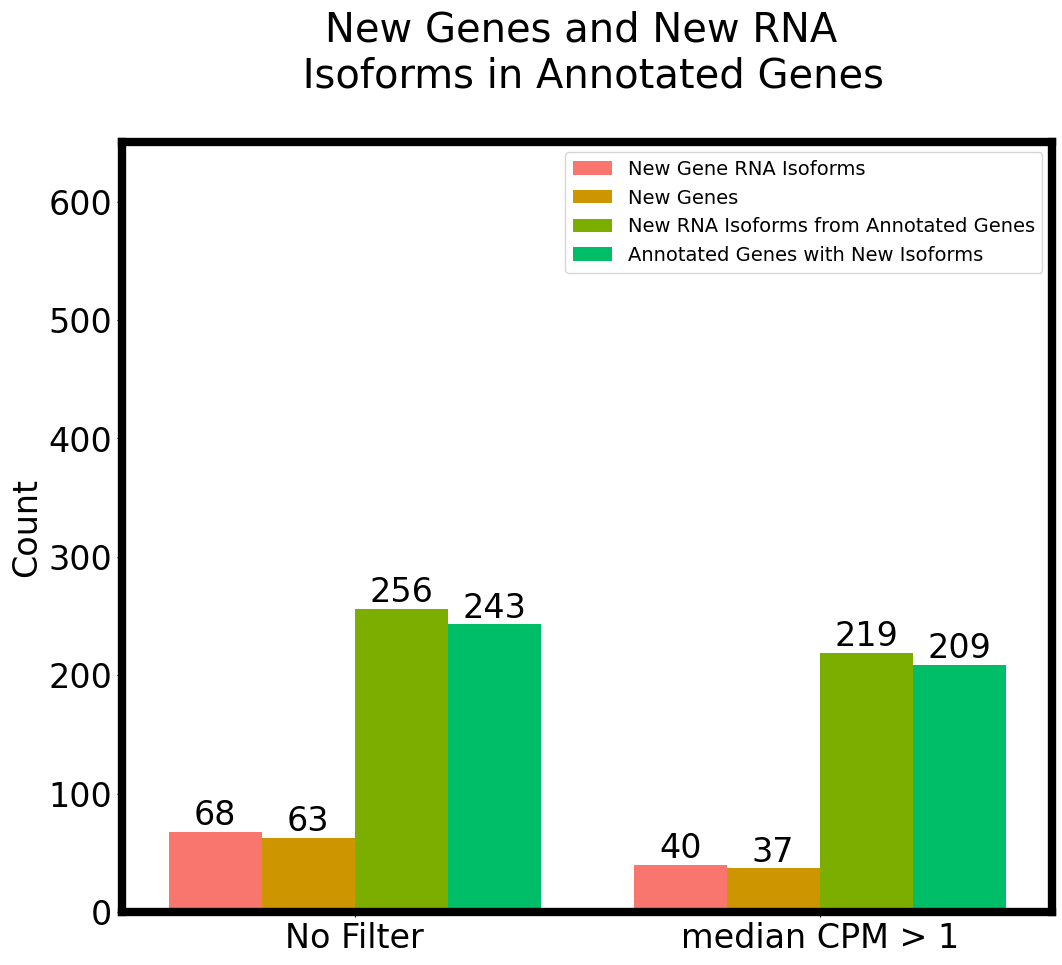

In [31]:
## Make barplot for number of new genes and transcripts

# figure size in inches
rcParams['figure.figsize'] = 12,10
rcParams.update({'font.size': 24})
rcParams['axes.linewidth'] = 6

ax = sns.barplot(y=list_numbers, x=list_filters, hue=list_labels, palette=ggplot2_colors, saturation=1)

for container in ax.containers:
    ax.bar_label(container)
    
ax.set_ylim(0, 650)


plt.legend(loc="upper right", fontsize=14)
plt.ylabel('Count')
plt.title("New Genes and New RNA \n Isoforms in Annotated Genes\n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/03/barplot_number_of_new_genes_and_isoforms.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/03/barplot_number_of_new_genes_and_isoforms.svg',
            dpi=300, transparent=True, bbox_inches="tight")

In [32]:
# figure size in inches
rcParams['figure.figsize'] = 12,8
rcParams.update({'font.size': 24})
rcParams['axes.linewidth'] = 6

In [33]:
## Number of isoforms for novel genes (no filter)
num_iso_new_genes = df_novel_genes["gene_id"].value_counts().value_counts()

print(num_iso_new_genes)

1    58
2     5
Name: gene_id, dtype: int64


In [34]:
## Number of isoforms for novel genes (median CPM > 1)
num_iso_new_genes_median = df_novel_genes_median["gene_id"].value_counts().value_counts()

print(num_iso_new_genes_median)

1    34
2     3
Name: gene_id, dtype: int64


In [35]:
## Number of new isoforms for transcripts mapping to annotated genes (no filter)
num_iso_new_transcripts = df_novel_transcripts["gene_id"].value_counts().value_counts()

print(num_iso_new_transcripts)

1    231
2     11
3      1
Name: gene_id, dtype: int64


In [36]:
## Number of new isoforms for transcripts mapping to annotated genes (median CPM > 1)
num_iso_new_transcripts_median = df_novel_transcripts_median["gene_id"].value_counts().value_counts()

print(num_iso_new_transcripts_median)

1    199
2     10
Name: gene_id, dtype: int64


In [37]:
## Create lists that will go into the graph for number of genes with multiple new isoforms

numbers = [num_iso_new_genes.to_list(), num_iso_new_genes_median.to_list(),
          num_iso_new_transcripts.to_list(), num_iso_new_transcripts_median.to_list()]

filters_list = ["No Filter", "No Filter", "median CPM > 1", "median CPM > 1", "No Filter", "No Filter",
                "median CPM > 1", "median CPM > 1"]

description_list = ["New Gene 1 Isoform", "New Gene 2+ Isoforms",
               "New Gene 1 Isoform", "New Gene 2+ Isoforms", "Annotated Gene 1 New Isoform", 
                "Annotated Gene 2+ New Isoform", "Annotated Gene 1 New Isoform", "Annotated Gene 2+ New Isoform"]

In [38]:
## Create list with number of genes with 1 isoform an multiple isoforms across stringency thresholds.
## Separate by new genes and annotated genes

list_numbers = []

for i in range(len(numbers)):
    
    sum_multiple_iso = 0
    
    if len(numbers[i]) == 1:
        
        numbers_list.append(numbers[i][0]) 
        numbers_list.append(0)
    
    else:
        
        for j in range(len(numbers[i])):
        
            if j == 0:
                list_numbers.append(numbers[i][j])
            
            else:
                sum_multiple_iso += numbers[i][j]
        
        list_numbers.append(sum_multiple_iso)
        sum_multiple_iso = 0  

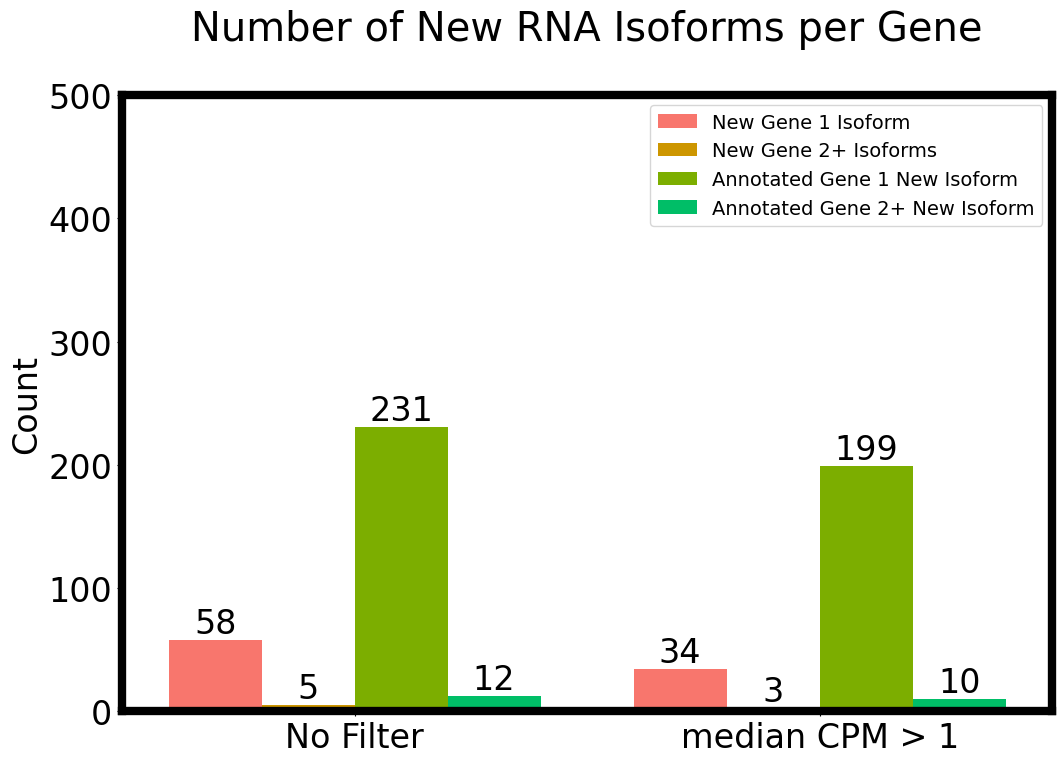

In [39]:
## Make graph for number of new genes with multiple isoforms
ax = sns.barplot(y=list_numbers, x=filters_list, hue=description_list, palette=ggplot2_colors, saturation=1)

for container in ax.containers:
    ax.bar_label(container)
    
ax.set_ylim(0, 500)


plt.legend(loc="upper right", fontsize=14)
plt.ylabel('Count')
plt.title("Number of New RNA Isoforms per Gene\n")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/03/barplot_number_of_rna_isoforms_per_gene.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/03/barplot_number_of_rna_isoforms_per_gene.svg',
            dpi=300, transparent=True, bbox_inches="tight")

# 4) Quantification of events giving origin to new isoforms in annotated transcripts.

In [40]:
## Import Data
df_events = pd.read_csv("../../../data/bernardo/processed/03.gene_and_transcripts_descriptive_stats/uky_aged_stringent_novel_events.tsv", sep="\t")

In [41]:
## Remove new genes
df_events = df_events.loc[df_events["txClassDescription"] != "newGene-spliced"].copy()

In [42]:
## Cleanup net transcript classes
df_events.loc[df_events["txClassDescription"] == "newWithin", "txClassDescription"] = "New combination of known exons & junctions"
df_events.loc[df_events["txClassDescription"] == "newFirstJunction:newFirstExon", "txClassDescription"] = "New exon"
df_events.loc[df_events["txClassDescription"] == "newLastJunction:newLastExon", "txClassDescription"] = "New exon"
df_events.loc[df_events["txClassDescription"] == "newFirstJunction", "txClassDescription"] = "New exon"
df_events.loc[df_events["txClassDescription"] == "allNew", "txClassDescription"] = "All new exons and junctions"

df_events.loc[df_events["txClassDescription"] == "newFirstJunction", "txClassDescription"] = "New junction"
df_events.loc[df_events["txClassDescription"] == "newLastJunction:newJunction", "txClassDescription"] = "New junction"
df_events.loc[df_events["txClassDescription"] == "newFirstJunction:newJunction", "txClassDescription"] = "New junction"
df_events.loc[df_events["txClassDescription"] == "newLastJunction", "txClassDescription"] = "New junction"
df_events.loc[df_events["txClassDescription"] == "newJunction", "txClassDescription"] = "New junction"

df_events.loc[df_events["txClassDescription"] == "newLastJunction:newJunction:newLastExon", "txClassDescription"] = "New exon & new junction"
df_events.loc[df_events["txClassDescription"] == "newFirstJunction:newJunction:newFirstExon", "txClassDescription"] = "New exon & new junction"
df_events.loc[df_events["txClassDescription"] == "newLastJunction:newFirstJunction:newJunction:newFirstExon:newLastExon", "txClassDescription"] = "New exon & new junction"
df_events.loc[df_events["txClassDescription"] == "newLastJunction:newFirstJunction:newJunction:newFirstExon", "txClassDescription"] = "New exon & new junction"


In [43]:
## Create dataframes for the two stringency thresholds
df_events_median = df_events.loc[df_events["TXNAME"].isin(df_novel_transcripts_median["transcript_id"])]


In [44]:
## Get counts of events no filter
df_events["txClassDescription"].value_counts()

All new exons and junctions                   95
New combination of known exons & junctions    60
New junction                                  52
New exon                                      32
New exon & new junction                       17
Name: txClassDescription, dtype: int64

In [45]:
## Get counts of events median CPM > 1
df_events_median["txClassDescription"].value_counts()

All new exons and junctions                   82
New combination of known exons & junctions    56
New junction                                  41
New exon                                      28
New exon & new junction                       12
Name: txClassDescription, dtype: int64

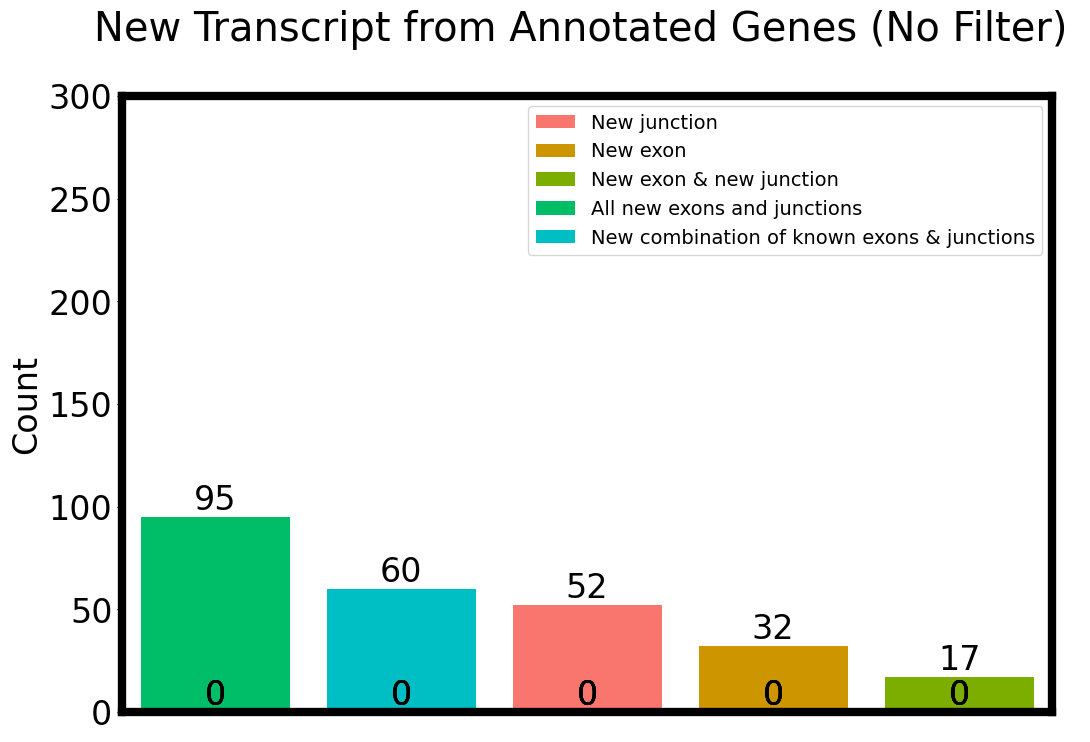

In [46]:
## Make graph of new transcript events for no filter

ax = sns.countplot(x=df_events["txClassDescription"], hue=df_events["txClassDescription"], dodge=False, palette=ggplot2_colors, saturation=1,
                  order=df_events["txClassDescription"].value_counts().index)

for container in ax.containers:
    ax.bar_label(container)
    
ax.set_ylim(0, 300)

plt.xticks(rotation=90)
plt.tick_params(labelsize=None)

plt.legend(loc="upper right", fontsize=14)
plt.ylabel('Count')
plt.xlabel("")
plt.title("New Transcript from Annotated Genes (No Filter) \n")
plt.xticks([]) 

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/04/barplot_events_new_transcripts_no_filter.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/04/barplot_events_new_transcripts_no_filter.svg',
           dpi=300, transparent=True, bbox_inches="tight")

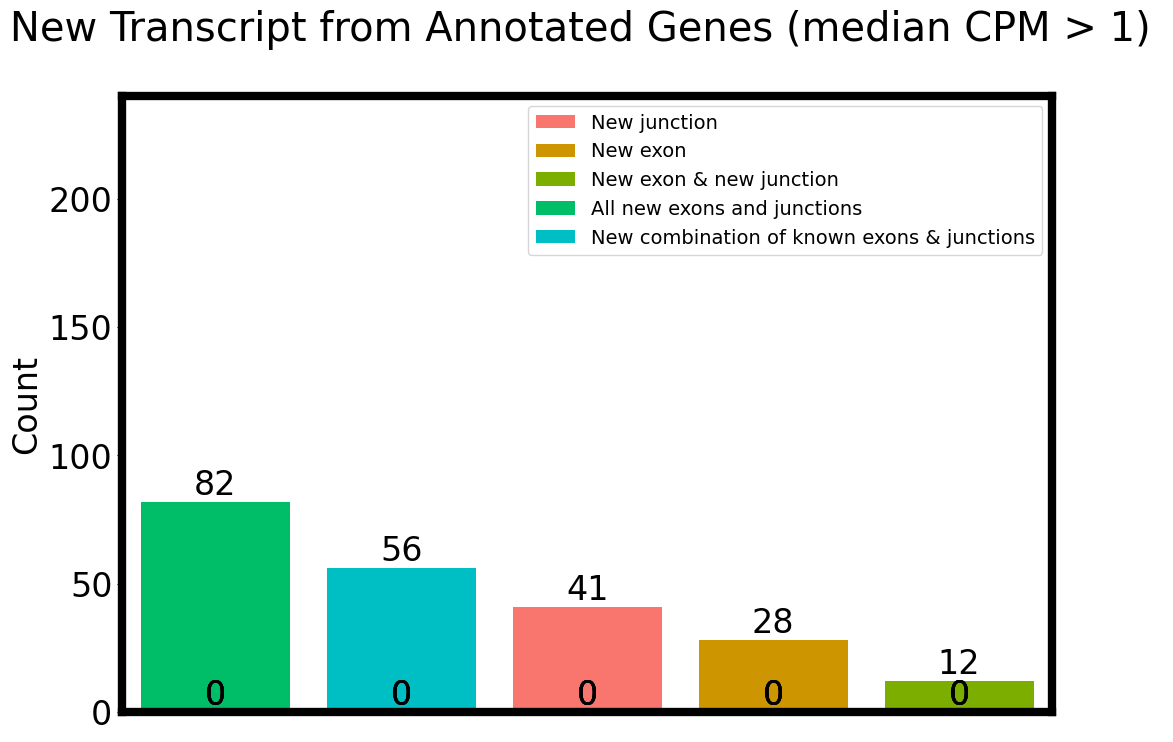

In [47]:
## Make graph of new transcript events for median CPM > 1

ax = sns.countplot(x=df_events_median["txClassDescription"], hue=df_events_median["txClassDescription"], dodge=False, palette=ggplot2_colors, saturation=1,
                  order=df_events_median["txClassDescription"].value_counts().index)

for container in ax.containers:
    ax.bar_label(container)
    
ax.set_ylim(0, 240)

plt.xticks(rotation=90)
plt.tick_params(labelsize=None)



plt.legend(loc="upper right", fontsize=14)
plt.ylabel('Count')
plt.xlabel("")
plt.title("New Transcript from Annotated Genes (median CPM > 1) \n")
plt.xticks([]) 

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/04/barplot_events_new_transcripts_median.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/04/barplot_events_new_transcripts_median.svg',
           dpi=300, transparent=True, bbox_inches="tight")

# 5) Wordcloud for protein coding and medically relvant transcripts

In [48]:
## Open original reference
original_ref = pd.read_csv("../../../references/bernardo/Homo_sapiens.GRCh38.107_ERCC.gtf", header=None, delimiter="\t", low_memory=False, 
                       names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"], comment="#")

In [49]:
## Parse through reference to get gene names and ids
orig_ref = original_ref.loc[original_ref["type"]=="gene"].copy()
orig_ref = parse_df_columns(orig_ref, is_ref=True)

In [50]:
## Import disease relevant genes
disease_relevant_genes = pd.read_csv("../../../references/bernardo/medically_relevant_genes.tsv", sep="\t")

## Import AD Genes
ad_names = pd.read_csv("../../../references/bernardo/AD_gwas_genes.tsv", sep="\t")

In [51]:
## Create disease relevant list including chromosome
disease_relevant_genes_annotated = disease_relevant_genes.merge(orig_ref[["gene_id", "gene_name", "chr"]], 
                                                               how="inner", on=["gene_id", "gene_name"])

In [52]:
## Create list of protein coding genes
protein_coding_ref = orig_ref.loc[orig_ref["gene_biotype"] == "protein_coding"].copy()

In [53]:
## Create list o disease relevant novel transcripts for three stringency thresholds
novel_relevant = df_novel_transcripts.merge(disease_relevant_genes_annotated[["gene_id", "gene_name", "chr"]], 
                                                                             on=["gene_id"], how="inner")

novel_relevant_median = df_novel_transcripts_median.merge(disease_relevant_genes_annotated[["gene_id", "gene_name", "chr"]], 
                                                                             on=["gene_id"], how="inner")


df_novel_transcripts_median_5 = df_novel_transcripts_median.loc[df_novel_transcripts_median["median_CPM"] > 5].copy()
novel_relevant_median_5 = df_novel_transcripts_median_5.merge(disease_relevant_genes_annotated[["gene_id", "gene_name", "chr"]], 
                                                                             on=["gene_id"], how="inner")

In [54]:
## Create list of novel transcripts belonging to protein coding genes for three stringency thresholds
protein_relevant = df_novel_transcripts.merge(protein_coding_ref[["gene_id", "gene_name", "chr"]], 
                                                                             on=["gene_id"], how="inner")

protein_relevant_median = df_novel_transcripts_median.merge(protein_coding_ref[["gene_id", "gene_name", "chr"]], 
                                                                             on=["gene_id"], how="inner")

protein_relevant_median_5 = df_novel_transcripts_median_5.merge(protein_coding_ref[["gene_id", "gene_name", "chr"]], 
                                                                             on=["gene_id"], how="inner")

In [55]:
## Drop any duplicates
novel_relevant.drop_duplicates(inplace=True)
novel_relevant_median.drop_duplicates(inplace=True)
novel_relevant_median_5.drop_duplicates(inplace=True)

protein_relevant.drop_duplicates(inplace=True)
protein_relevant_median.drop_duplicates(inplace=True)
protein_relevant_median_5.drop_duplicates(inplace=True)

In [56]:
## Remove MT transcripts
novel_relevant = novel_relevant.loc[novel_relevant["chr"] != "MT"]
novel_relevant_median = novel_relevant_median.loc[novel_relevant_median["chr"] != "MT"]
novel_relevant_median_5 = novel_relevant_median_5.loc[novel_relevant_median_5["chr"] != "MT"]

protein_relevant = protein_relevant.loc[protein_relevant["chr"] != "MT"]
protein_relevant_median = protein_relevant_median.loc[protein_relevant_median["chr"] != "MT"]
protein_relevant_median_5 = protein_relevant_median_5.loc[protein_relevant_median_5["chr"] != "MT"]

In [57]:
## Get all transcript from the same gene as the new transcripts so we can calculate relative abundance of 
## New transcripts in each gene
novel_relevant_counts = pd.merge(df, novel_relevant[["gene_id", "gene_name"]], on=["gene_id"], how="inner")
novel_relevant_median_counts = pd.merge(df, novel_relevant_median[["gene_id", "gene_name"]], on=["gene_id"], how="inner")
novel_relevant_median_5_counts = pd.merge(df, novel_relevant_median_5[["gene_id", "gene_name"]], on=["gene_id"], how="inner")

protein_relevant_counts = pd.merge(df, protein_relevant[["gene_id", "gene_name"]], on=["gene_id"], how="inner")
protein_relevant_median_counts = pd.merge(df, protein_relevant_median[["gene_id", "gene_name"]], on=["gene_id"], how="inner")
protein_relevant_median_5_counts = pd.merge(df, protein_relevant_median_5[["gene_id", "gene_name"]], on=["gene_id"], how="inner")

In [58]:
## Calculate relative transcript abundance
novel_relevant_relative_abundance = relative_transcript_abundance(novel_relevant_counts)
novel_relevant_median_relative_abundance = relative_transcript_abundance(novel_relevant_median_counts)
novel_relevant_median_5_relative_abundance = relative_transcript_abundance(novel_relevant_median_5_counts)

protein_relevant_relative_abundance = relative_transcript_abundance(protein_relevant_counts)
protein_relevant_median_relative_abundance = relative_transcript_abundance(protein_relevant_median_counts)
protein_relevant_median_5_relative_abundance = relative_transcript_abundance(protein_relevant_median_5_counts)

In [59]:
## Annotate novel transcripts on relative abundance table
novel_relevant_relative_abundance.loc[novel_relevant_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = True
novel_relevant_relative_abundance.loc[~novel_relevant_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = False

novel_relevant_median_relative_abundance.loc[novel_relevant_median_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = True
novel_relevant_median_relative_abundance.loc[~novel_relevant_median_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = False

novel_relevant_median_5_relative_abundance.loc[novel_relevant_median_5_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = True
novel_relevant_median_5_relative_abundance.loc[~novel_relevant_median_5_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = False



protein_relevant_relative_abundance.loc[protein_relevant_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = True
protein_relevant_relative_abundance.loc[~protein_relevant_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = False

protein_relevant_median_relative_abundance.loc[protein_relevant_median_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = True
protein_relevant_median_relative_abundance.loc[~protein_relevant_median_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = False

protein_relevant_median_5_relative_abundance.loc[protein_relevant_median_5_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = True
protein_relevant_median_5_relative_abundance.loc[~protein_relevant_median_5_relative_abundance["transcript_id"].str.startswith("BambuTx"), "is_novel_transcript"] = False

In [60]:
## Create list with med relevant genes with novel isoforms and their relative frequency
novel_relevant_words = novel_relevant_relative_abundance.loc[novel_relevant_relative_abundance["is_novel_transcript"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()

novel_relevant_median_words = novel_relevant_median_relative_abundance.loc[novel_relevant_median_relative_abundance["is_novel_transcript"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()

novel_relevant_median_5_words = novel_relevant_median_5_relative_abundance.loc[novel_relevant_median_5_relative_abundance["is_novel_transcript"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()


protein_relevant_words = protein_relevant_relative_abundance.loc[protein_relevant_relative_abundance["is_novel_transcript"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()

protein_relevant_median_words = protein_relevant_median_relative_abundance.loc[protein_relevant_median_relative_abundance["is_novel_transcript"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()

protein_relevant_median_5_words = protein_relevant_median_5_relative_abundance.loc[protein_relevant_median_5_relative_abundance["is_novel_transcript"]
                                                             == True][["gene_name", "relative_abundance_percent"]].copy()

In [61]:
## Drop duplicates
novel_relevant_words = novel_relevant_words.drop_duplicates()
novel_relevant_median_words = novel_relevant_median_words.drop_duplicates()
novel_relevant_median_5_words = novel_relevant_median_5_words.drop_duplicates()


protein_relevant_words = protein_relevant_words.drop_duplicates()
protein_relevant_median_words = protein_relevant_median_words.drop_duplicates()
protein_relevant_median_5_words = protein_relevant_median_5_words.drop_duplicates()

In [62]:
## Sum relative abundance of all novel isoforms by gene name and round to nearest integer
novel_relevant_words = round(novel_relevant_words.groupby("gene_name")["relative_abundance_percent"].sum(), 0)
novel_relevant_median_words = round(novel_relevant_median_words.groupby("gene_name")["relative_abundance_percent"].sum(), 0)
novel_relevant_median_5_words = round(novel_relevant_median_5_words.groupby("gene_name")["relative_abundance_percent"].sum(), 0)


protein_relevant_words = round(protein_relevant_words.groupby("gene_name")["relative_abundance_percent"].sum(), 0)
protein_relevant_median_words = round(protein_relevant_median_words.groupby("gene_name")["relative_abundance_percent"].sum(), 0)
protein_relevant_median_5_words = round(protein_relevant_median_5_words.groupby("gene_name")["relative_abundance_percent"].sum(), 0)

In [63]:
## Create a dataframe to properly store the data
novel_relevant_words_df = pd.DataFrame()
novel_relevant_words_df['word_count'] = novel_relevant_words
novel_relevant_words_df["gene_name"] = novel_relevant_words.index

novel_relevant_median_words_df = pd.DataFrame()
novel_relevant_median_words_df['word_count'] = novel_relevant_median_words
novel_relevant_median_words_df["gene_name"] = novel_relevant_median_words.index

novel_relevant_median_5_words_df = pd.DataFrame()
novel_relevant_median_5_words_df['word_count'] = novel_relevant_median_5_words
novel_relevant_median_5_words_df["gene_name"] = novel_relevant_median_5_words.index


protein_relevant_words_df = pd.DataFrame()
protein_relevant_words_df['word_count'] = protein_relevant_words
protein_relevant_words_df["gene_name"] = protein_relevant_words.index

protein_relevant_median_words_df = pd.DataFrame()
protein_relevant_median_words_df['word_count'] = protein_relevant_median_words
protein_relevant_median_words_df["gene_name"] = protein_relevant_median_words.index

protein_relevant_median_5_words_df = pd.DataFrame()
protein_relevant_median_5_words_df['word_count'] = protein_relevant_median_5_words
protein_relevant_median_5_words_df["gene_name"] = protein_relevant_median_5_words.index

In [64]:
## Drop index
novel_relevant_words_df.reset_index(inplace=True, drop=True)
novel_relevant_median_words_df.reset_index(inplace=True, drop=True)
novel_relevant_median_5_words_df.reset_index(inplace=True, drop=True)


protein_relevant_words_df.reset_index(inplace=True, drop=True)
protein_relevant_median_words_df.reset_index(inplace=True, drop=True)
protein_relevant_median_5_words_df.reset_index(inplace=True, drop=True)

In [65]:
## Print number of disease relevant genes with high-confidence novel isoforms
print("Number of medically relevant genes with novel transcripts (No Filter):", novel_relevant_words_df["gene_name"].nunique())
print("Number of medically relevant genes with novel transcripts (median CPM > 1):", novel_relevant_median_words_df["gene_name"].nunique())
print("Number of medically relevant genes with novel transcripts (median CPM > 5):", novel_relevant_median_5_words_df["gene_name"].nunique())


print("\n\nNumber of protein coding genes with novel transcripts (No Filter):", protein_relevant_words_df["gene_name"].nunique())
print("Number of protein coding genes with novel transcripts (median CPM > 1):", protein_relevant_median_words_df["gene_name"].nunique())
print("Number of protein coding genes with novel transcripts (median CPM > 5):", protein_relevant_median_5_words_df["gene_name"].nunique())

Number of medically relevant genes with novel transcripts (No Filter): 24
Number of medically relevant genes with novel transcripts (median CPM > 1): 22
Number of medically relevant genes with novel transcripts (median CPM > 5): 12


Number of protein coding genes with novel transcripts (No Filter): 142
Number of protein coding genes with novel transcripts (median CPM > 1): 128
Number of protein coding genes with novel transcripts (median CPM > 5): 71


In [66]:
## Generate word list with frequency of word being proportional to novel isoform relative abundance
## Novel relevant no filter

word_list_disease = ""

for i in range(len(novel_relevant_words_df)):
        
    for j in range(int(novel_relevant_words_df.iloc[i][0])):
        word_list_disease = word_list_disease + novel_relevant_words_df.iloc[i][1] + " "

In [67]:
## Generate word list with frequency of word being proportional to novel isoform relative abundance
## Novel relevant median CPM > 1

word_list_disease_median = ""

for i in range(len(novel_relevant_median_words_df)):
        
    for j in range(int(novel_relevant_median_words_df.iloc[i][0])):
        word_list_disease_median = word_list_disease_median + novel_relevant_median_words_df.iloc[i][1] + " "

In [68]:
## Generate word list with frequency of word being proportional to novel isoform relative abundance
## Novel relevant median CPM > 5

word_list_disease_median_5 = ""

for i in range(len(novel_relevant_median_5_words_df)):
        
    for j in range(int(novel_relevant_median_5_words_df.iloc[i][0])):
        word_list_disease_median_5 = word_list_disease_median_5 + novel_relevant_median_5_words_df.iloc[i][1] + " "

In [69]:
## Generate word list with frequency of word being proportional to novel isoform relative abundance
## Protein relevant no filter

word_list_protein = ""

for i in range(len(protein_relevant_words_df)):
        
    for j in range(int(protein_relevant_words_df.iloc[i][0])):
        word_list_protein = word_list_protein + protein_relevant_words_df.iloc[i][1] + " "

In [70]:
## Generate word list with frequency of word being proportional to novel isoform relative abundance
## Protein relevant median CPM > 1

word_list_protein_median = ""

for i in range(len(protein_relevant_median_words_df)):
        
    for j in range(int(protein_relevant_median_words_df.iloc[i][0])):
        word_list_protein_median = word_list_protein_median + protein_relevant_median_words_df.iloc[i][1] + " "

In [71]:
## Generate word list with frequency of word being proportional to novel isoform relative abundance
## Protein relevant median CPM > 5

word_list_protein_median_5 = ""

for i in range(len(protein_relevant_median_5_words_df)):
        
    for j in range(int(protein_relevant_median_5_words_df.iloc[i][0])):
        word_list_protein_median_5 = word_list_protein_median_5 + protein_relevant_median_5_words_df.iloc[i][1] + " "

In [72]:
## Create GGPLOT2 colormap for the wordcloud (THANKS MARK!)

from matplotlib.colors import LinearSegmentedColormap

ggplot2_colormap = LinearSegmentedColormap.from_list(
        "ggplot_2", ggplot2_colors, N=8)

In [73]:
## Generate wordclouds
word_cloud_disease = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1000, height=1000).generate(word_list_disease)

word_cloud_disease_median = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1000, height=1000).generate(word_list_disease_median)

word_cloud_disease_median_5 = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1000, height=1000).generate(word_list_disease_median_5)



word_cloud_protein = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1000, height=1000).generate(word_list_protein)

word_cloud_protein_median = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1000, height=1000).generate(word_list_protein_median)

word_cloud_protein_median_5 = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap=ggplot2_colormap, prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=112,
                      width=1000, height=1000).generate(word_list_protein_median_5)

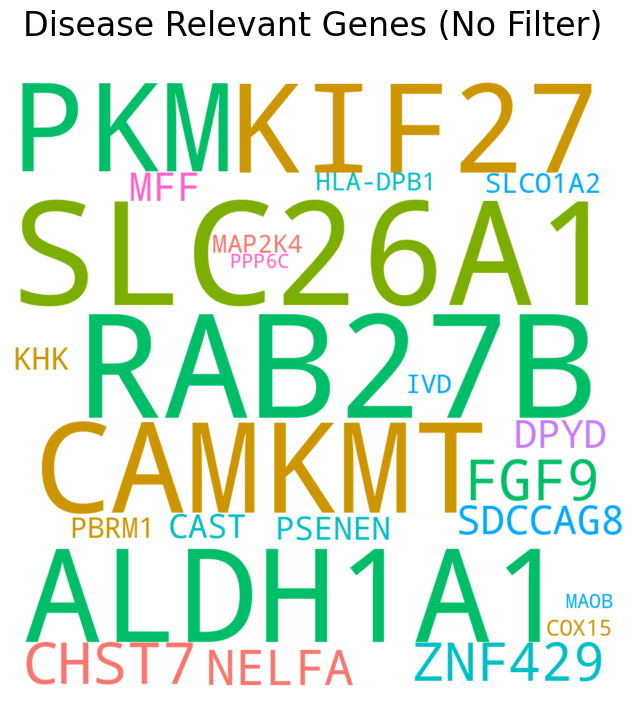

In [74]:
## Save disease relevant genes plot no filter
plt.imshow(word_cloud_disease, interpolation='bilinear', alpha=1)
plt.title("Disease Relevant Genes (No Filter) \n", fontsize=24)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/05/word_cloud_disease_no_filter.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/05/word_cloud_disease_no_filter.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

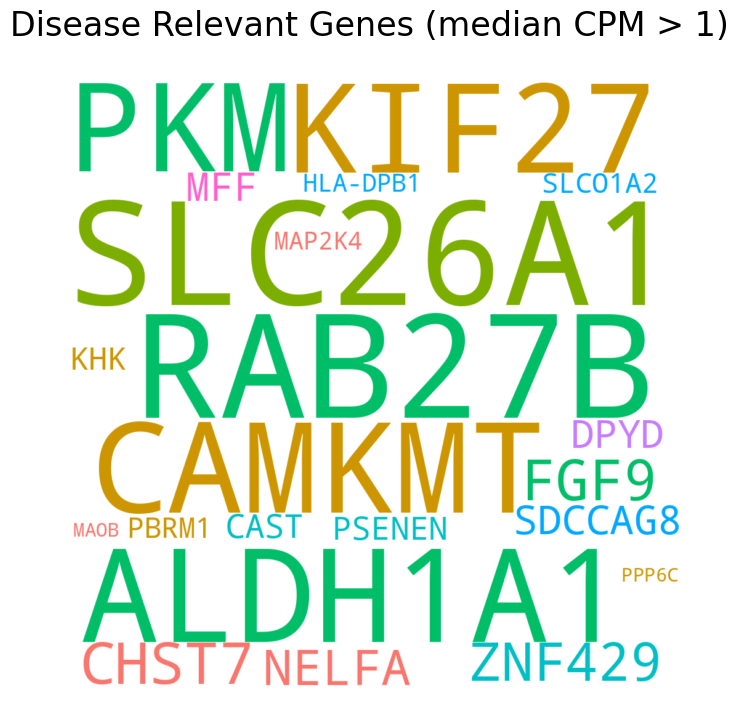

In [75]:
## Save disease relevant genes plot median CPM > 1
plt.imshow(word_cloud_disease_median, interpolation='bilinear', alpha=1)
plt.title("Disease Relevant Genes (median CPM > 1) \n", fontsize=24)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/05/word_cloud_disease_median.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/05/word_cloud_disease_median.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

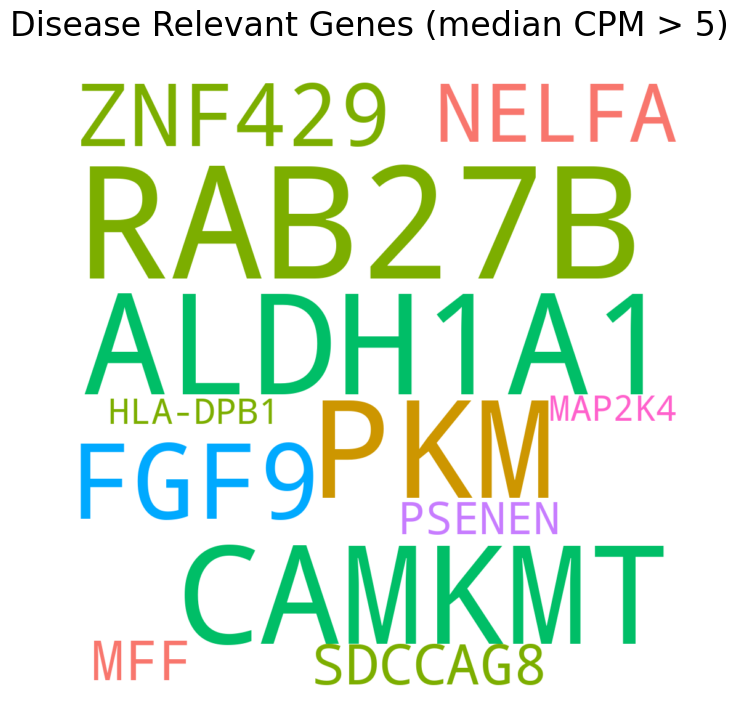

In [76]:
## Save disease relevant genes plot median CPM > 1
plt.imshow(word_cloud_disease_median_5, interpolation='bilinear', alpha=1)
plt.title("Disease Relevant Genes (median CPM > 5) \n", fontsize=24)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/05/word_cloud_disease_median_5.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/05/word_cloud_disease_median_5.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

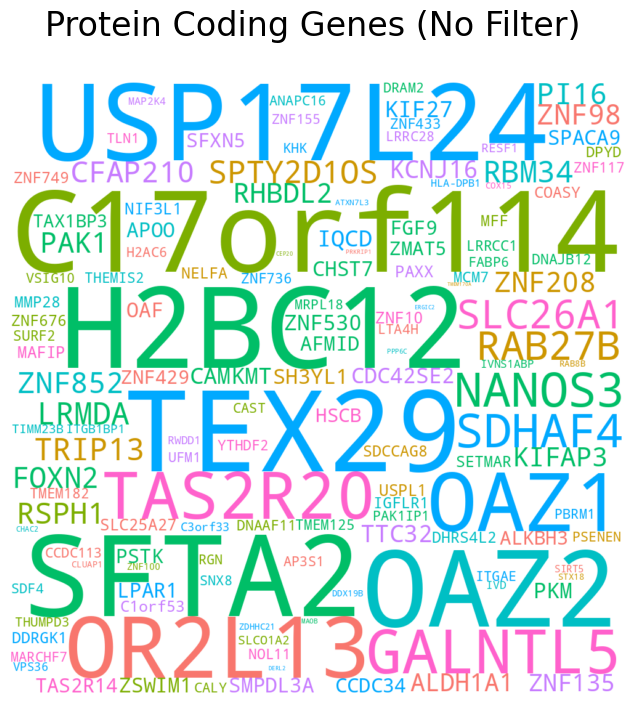

In [77]:
## Save disease relevant genes plot no filter
plt.imshow(word_cloud_protein, interpolation='bilinear')
plt.title("Protein Coding Genes (No Filter) \n", fontsize=24, alpha=1)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/05/word_cloud_protein_no_filter.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/05/word_cloud_protein_no_filter.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

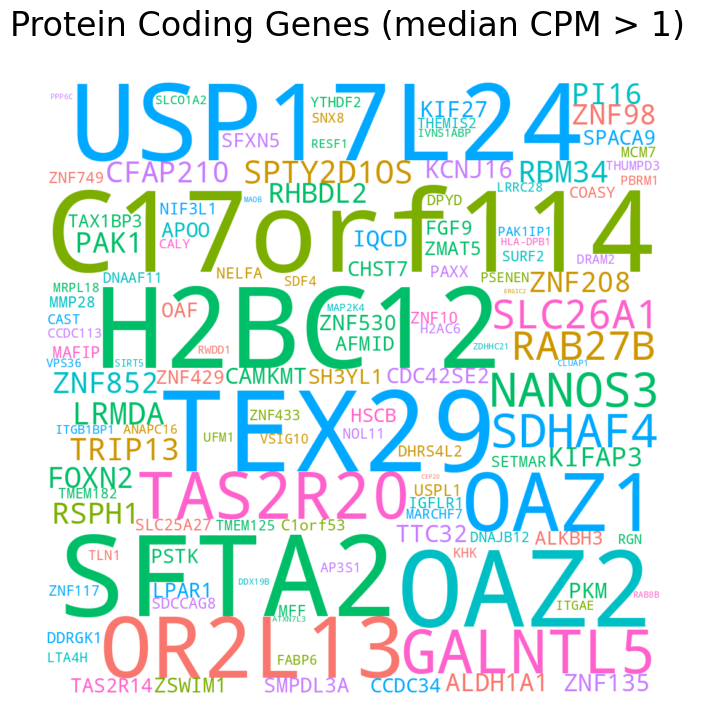

In [78]:
## Save disease relevant genes plot median CPM > 1
plt.imshow(word_cloud_protein_median, interpolation='bilinear', alpha=1)
plt.title("Protein Coding Genes (median CPM > 1) \n", fontsize=24)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/05/word_cloud_protein_median.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/05/word_cloud_protein_median.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

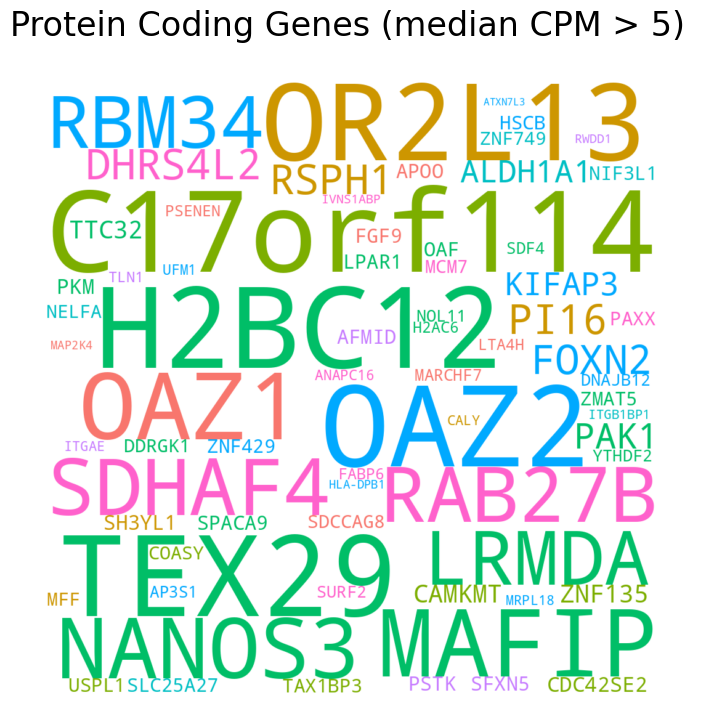

In [79]:
## Save disease relevant genes plot median CPM > 1
plt.imshow(word_cloud_protein_median_5, interpolation='bilinear', alpha=1)
plt.title("Protein Coding Genes (median CPM > 5) \n", fontsize=24)
plt.axis("off")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/05/word_cloud_protein_median_5.png',
            dpi=300, transparent=True, bbox_inches="tight")

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/05/word_cloud_protein_median_5.svg',
            dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [80]:
## Export lists of protein coding genes with novel transcripts and disease relevant genes with novel transcripts
## at median CPM > 1 and each CPM > 1

novel_relevant_median_words_df.to_csv("../../../data/bernardo/processed/99.other/create_annotations/annotations_and_quant_for_mark_and_maddy/new_transcripts_on_relevant_genes/medically_relevant_median_cpm.tsv",
                                  sep="\t", index=False)


protein_relevant_median_words_df.to_csv("../../../data/bernardo/processed/99.other/create_annotations/annotations_and_quant_for_mark_and_maddy/new_transcripts_on_relevant_genes/protein_coding_median_cpm.tsv",
                                  sep="\t", index=False)

# 6) General quantification of all transcripts

In [81]:
## Filter out ERCCs
df_general = df.loc[~df["gene_id"].str.startswith("ERCC")].copy()

In [82]:
## Create lists with number of genes across CPM thresholds
list_cpm_thresh = []
list_num_transcripts_median = []
list_num_genes_median = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    cpm_cols = df_general.columns[2:]
    
    transcript_median_num = df_general.loc[df_general["total_CPM"] >= cpm_thresh].shape[0]
    
    gene_median_num = df_general.loc[df_general["total_CPM"] >= cpm_thresh]["gene_id"].nunique()
    
    list_cpm_thresh.append(cpm_thresh)
    
    list_num_transcripts_median.append(transcript_median_num)
    
    list_num_genes_median.append(gene_median_num)
    

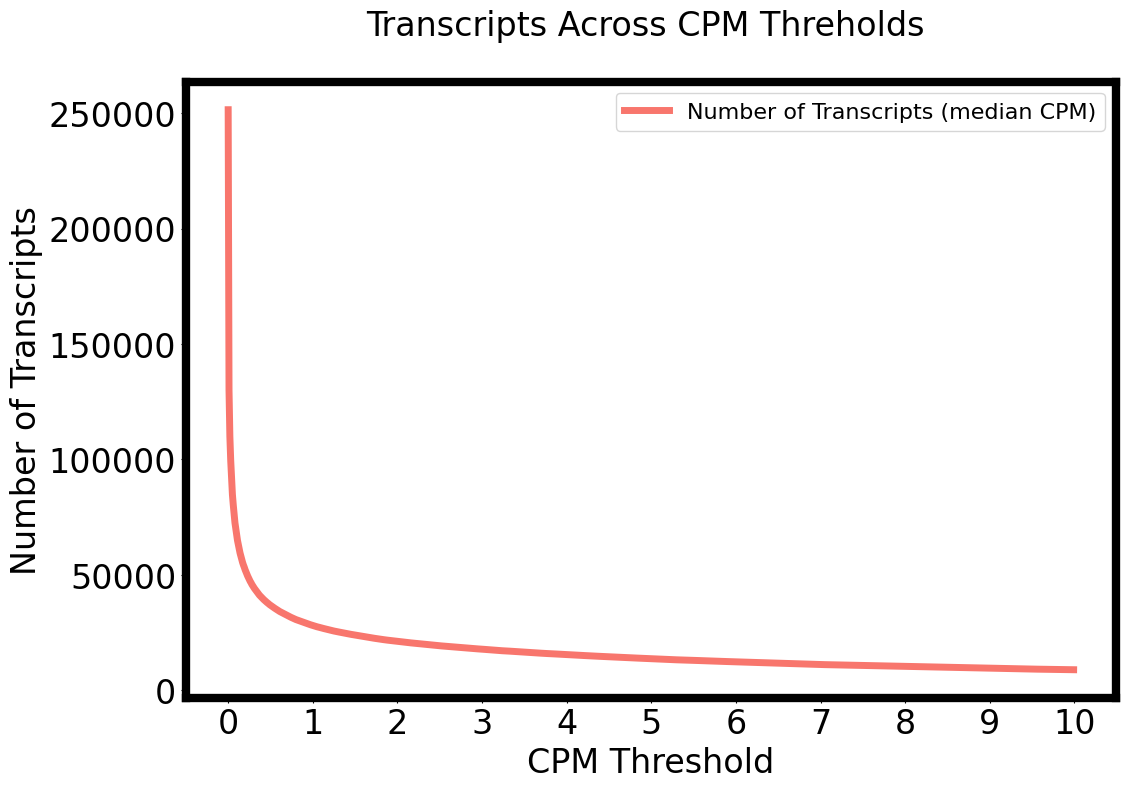

In [83]:
## Make plot showing number of transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_num_transcripts_median, color=ggplot2_colors[0], label="Number of Transcripts (median CPM)", linewidth=5, alpha=1)


plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Transcripts Across CPM Threholds \n", fontsize=24)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/06/number_of_transcripts_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/06/number_of_transcripts_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

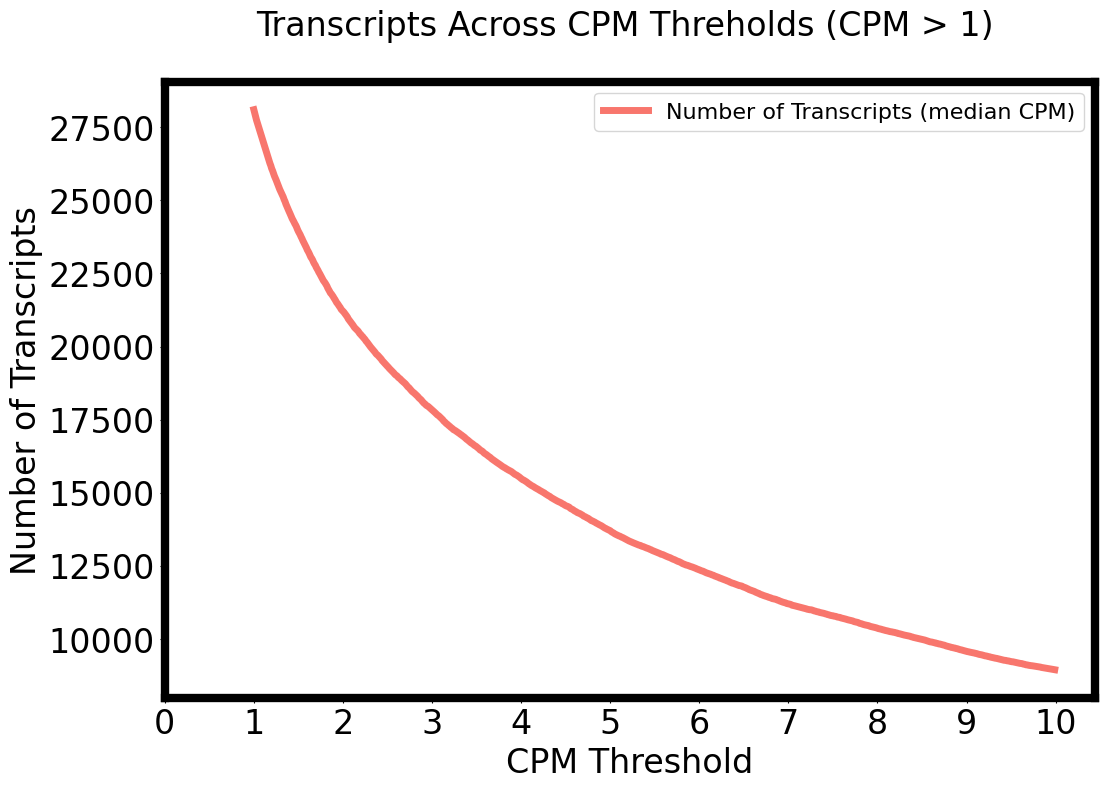

In [84]:
## Make plot showing number of transcripts across CPM thresholds starting at CPM > 0

plt.plot(list_cpm_thresh[100:], list_num_transcripts_median[100:], color=ggplot2_colors[0], label="Number of Transcripts (median CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Transcripts Across CPM Threholds (CPM > 1) \n", fontsize=24)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/06/number_of_transcripts_across_cpm_thresh_CPM_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/06/number_of_transcripts_across_cpm_thresh_CPM_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

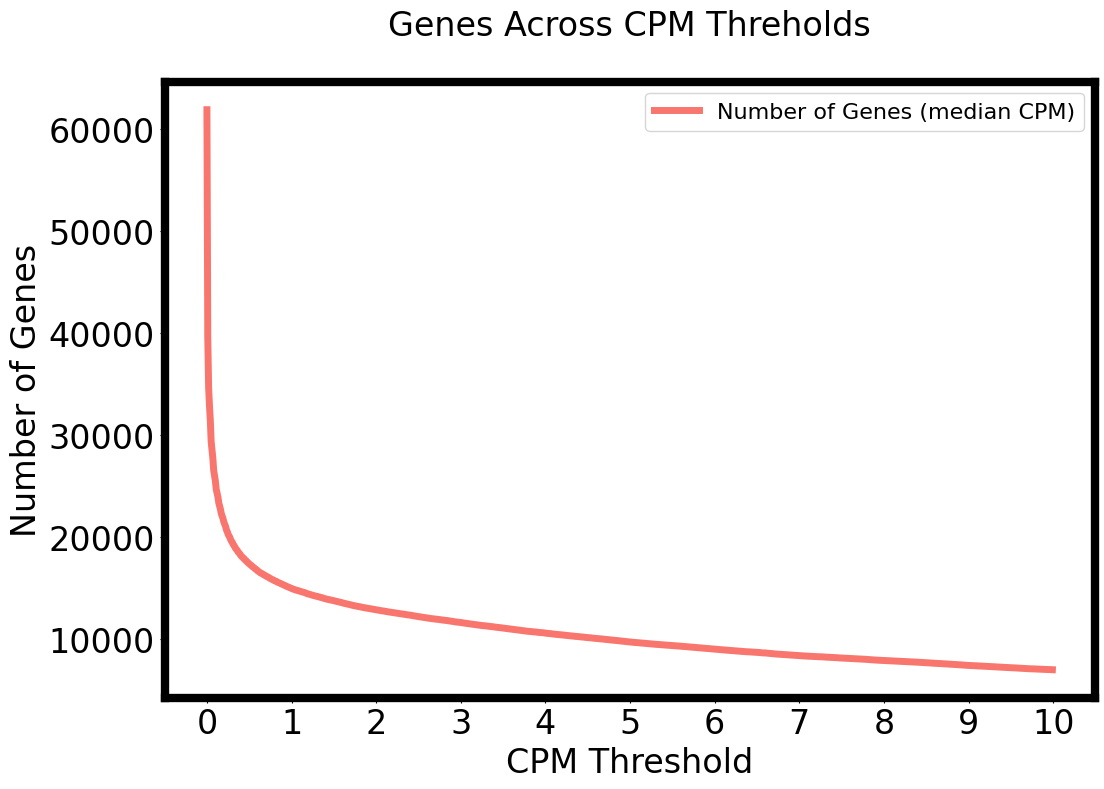

In [85]:
## Make plot showing number of genes across CPM thresholds (Both)

plt.plot(list_cpm_thresh, list_num_genes_median, color=ggplot2_colors[0], label="Number of Genes (median CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("Genes Across CPM Threholds\n", fontsize=24)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/06/number_of_genes_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/06/number_of_genes_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()


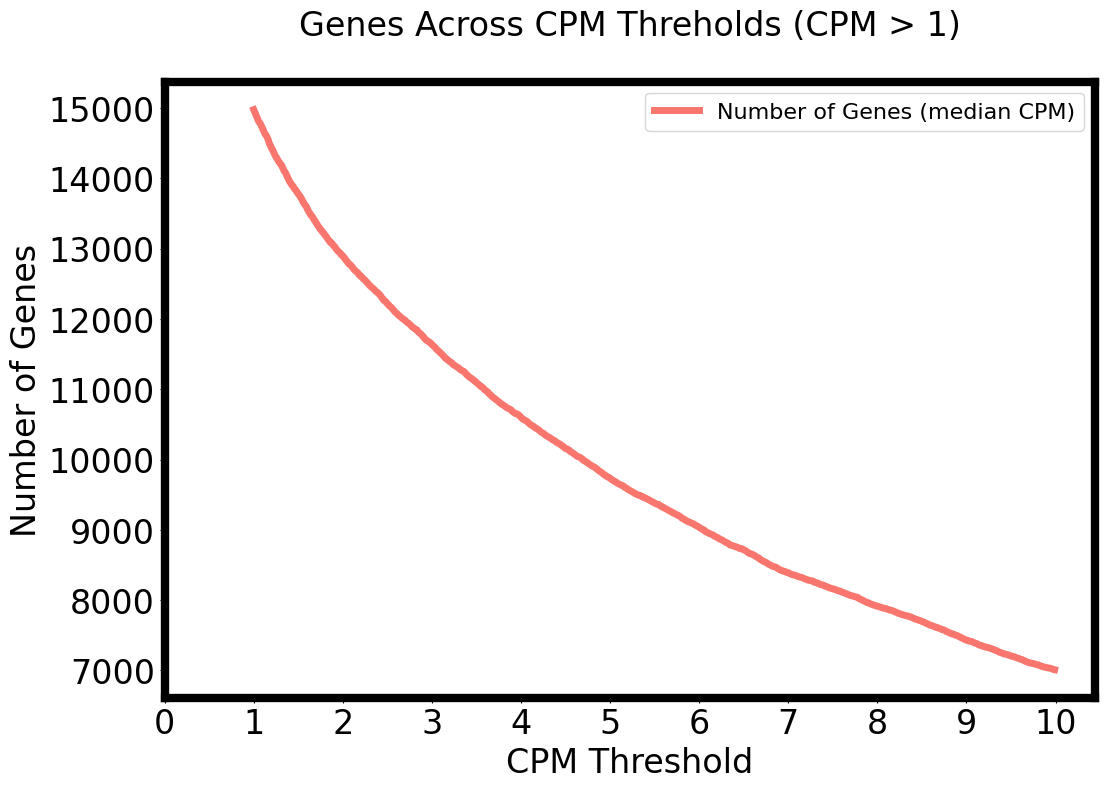

In [86]:
## Make plot showing number of genes across CPM thresholds only include CPM > 0

plt.plot(list_cpm_thresh[100:], list_num_genes_median[100:], color=ggplot2_colors[0], label="Number of Genes (median CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("Genes Across CPM Threholds (CPM > 1)\n", fontsize=24)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/06/number_of_genes_across_cpm_thresh_CPM_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/06/number_of_genes_across_cpm_thresh_CPM_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()


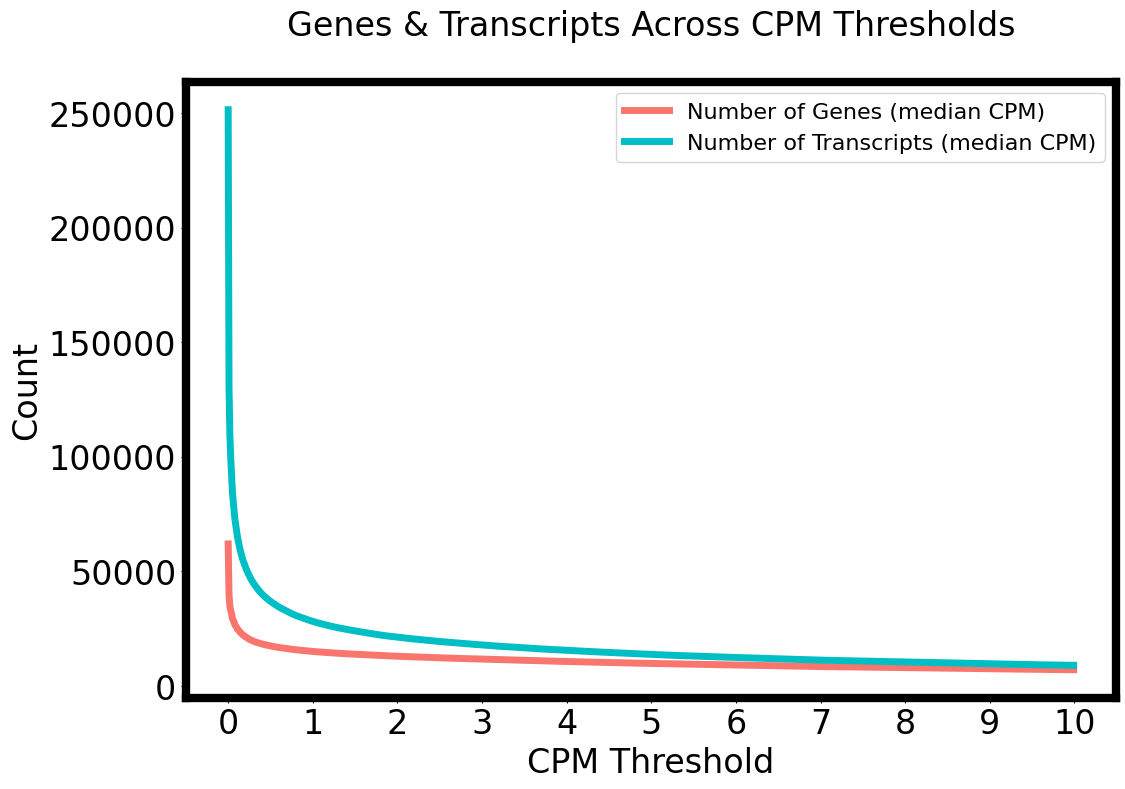

In [88]:
## Make plot showing number of genes and transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_num_genes_median, color=ggplot2_colors[0], label="Number of Genes (median CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_transcripts_median, color=ggplot2_colors[4], label="Number of Transcripts (median CPM)", linewidth=5, alpha=1)

plt.title("Genes & Transcripts Across CPM Thresholds\n", fontsize=24)
plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Count')
plt.legend(loc="upper right", fontsize=16)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/06/number_of_genes_and_transcripts_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/06/number_of_genes_and_transcripts_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

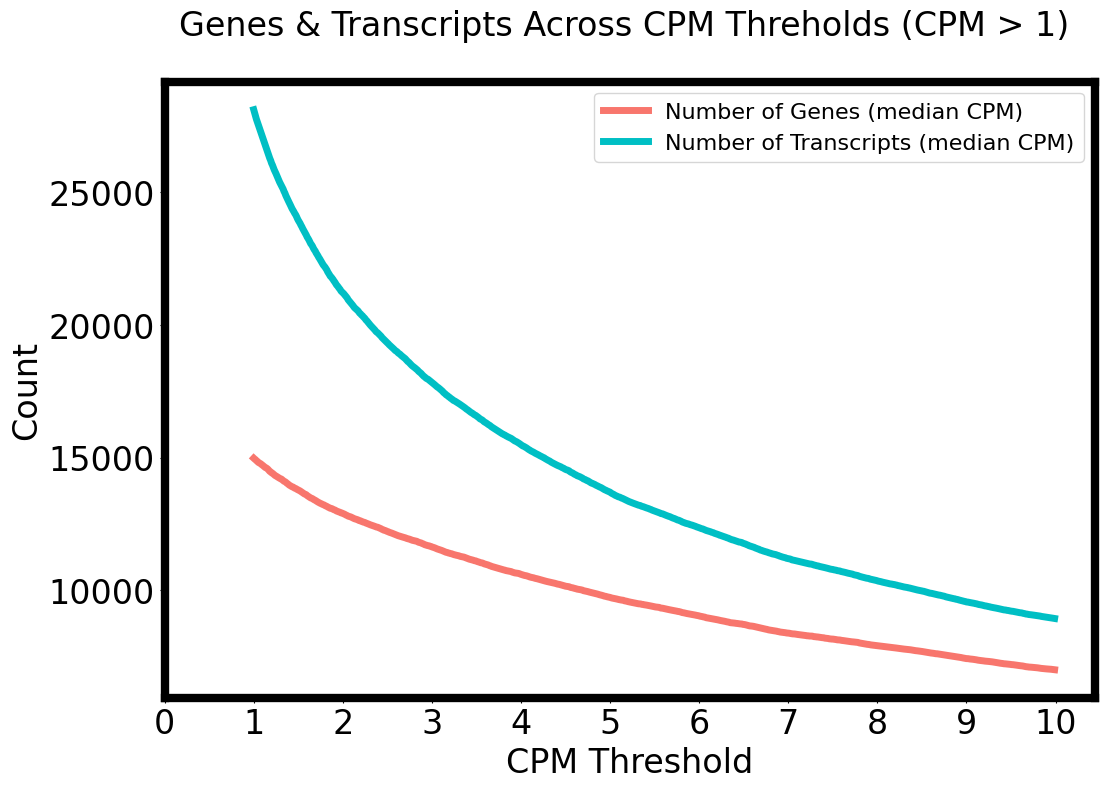

In [89]:
## Make plot showing number of genes and transcripts across CPM thresholds

plt.plot(list_cpm_thresh[100:], list_num_genes_median[100:], color=ggplot2_colors[0], label="Number of Genes (median CPM)", linewidth=5, alpha=1)


plt.plot(list_cpm_thresh[100:], list_num_transcripts_median[100:], color=ggplot2_colors[4], label="Number of Transcripts (median CPM)", linewidth=5, alpha=1)


plt.title("Genes & Transcripts Across CPM Threholds (CPM > 1) \n", fontsize=24)
plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Count')
plt.legend(loc="upper right", fontsize=16)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/06/number_of_genes_and_transcripts_across_cpm_thresh_CPM_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/06/number_of_genes_and_transcripts_across_cpm_thresh_CPM_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [90]:
## Parse through original GTF 107 Ensembl reference to get transcript biotypes
orig_ref_types = original_ref.loc[original_ref["type"]=="transcript"].copy()
orig_ref_types = parse_df_columns(orig_ref_types, is_ref=True, is_transcript=True)

In [91]:
## Get all transcript biotypes in expression matrix
df_general_and_type = df_general.merge(orig_ref_types[["transcript_id", "transcript_biotype"]], on="transcript_id", how="inner")
df_novel = df_general.loc[df_general["transcript_id"].str.startswith("BambuTx")].copy()
df_novel["transcript_biotype"] = "new_transcript"

df_general_and_type = pd.concat([df_general_and_type, df_novel])

In [92]:
## Create dataframes with transcript subtypes

df_protein_coding = df_general_and_type.loc[df_general_and_type["transcript_biotype"] == "protein_coding"].copy()
df_lncRNA = df_general_and_type.loc[df_general_and_type["transcript_biotype"] == "lncRNA"].copy()
df_new_transcript =  df_general_and_type.loc[df_general_and_type["transcript_biotype"] == "new_transcript"].copy()
df_other =  df_general_and_type.loc[~df_general_and_type["transcript_biotype"].isin(["protein_coding", "lncRNA", "new_transcript"])].copy()

In [93]:
## Create lists with number of genes across CPM thresholds
list_num_transcripts_median = [[], [], [], []]
list_dataframes = [df_protein_coding, df_lncRNA, df_new_transcript, df_other]

for i in range(0, 1000):
    for j in range(len(list_dataframes)):
        
        type_df = list_dataframes[j]
        
        cpm_thresh = i/100
        
        cpm_cols = type_df.columns[2:7]

        transcript_median_num = type_df.loc[type_df["total_CPM"] >= cpm_thresh].shape[0]

        list_num_transcripts_median[j].append(transcript_median_num)

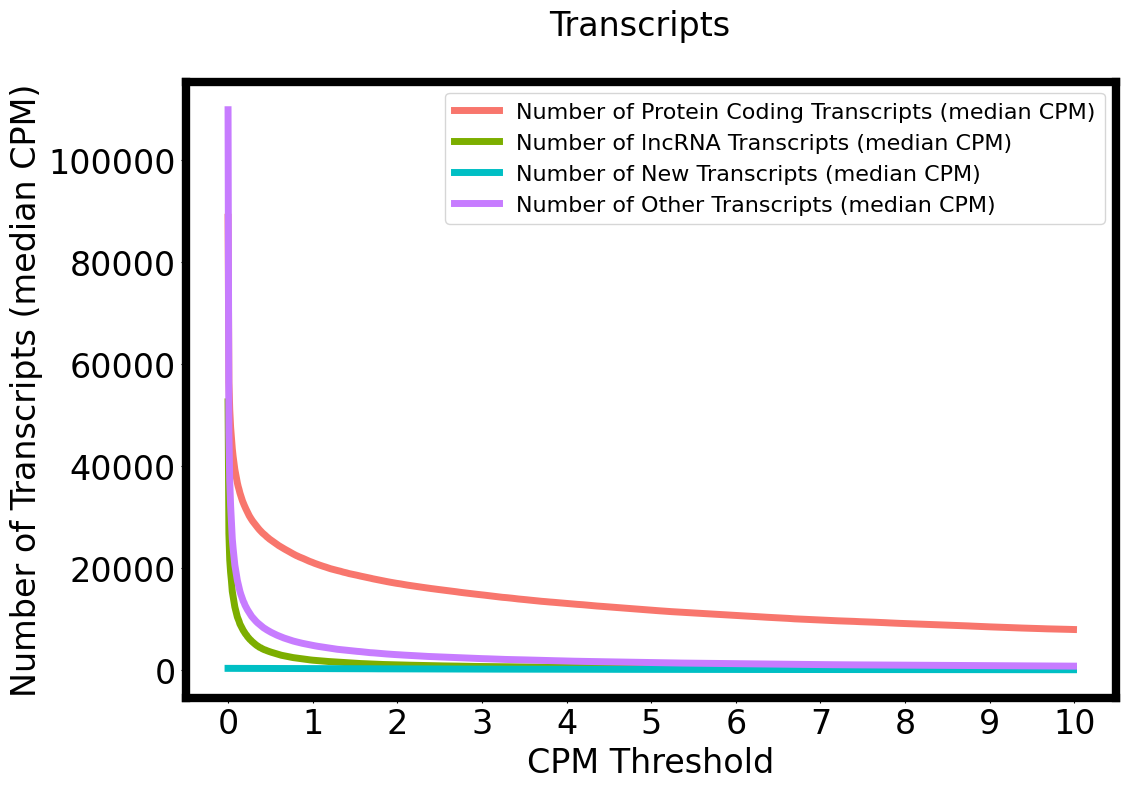

In [94]:
## Make plot showing number of transcripts across CPM thresholds with subtypes

plt.plot(list_cpm_thresh, list_num_transcripts_median[0], color=ggplot2_colors[0], label="Number of Protein Coding Transcripts (median CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_transcripts_median[1], color=ggplot2_colors[2], label="Number of lncRNA Transcripts (median CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_transcripts_median[2], color=ggplot2_colors[4], label="Number of New Transcripts (median CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_transcripts_median[3], color=ggplot2_colors[6], label="Number of Other Transcripts (median CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts (median CPM)')
plt.legend(loc="upper right", fontsize=16)
plt.title("Transcripts  \n", fontsize=24)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/06/number_of_transcripts_across_cpm_thresh_subtypes_median.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/06/number_of_transcripts_across_cpm_thresh_subtypes_median.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

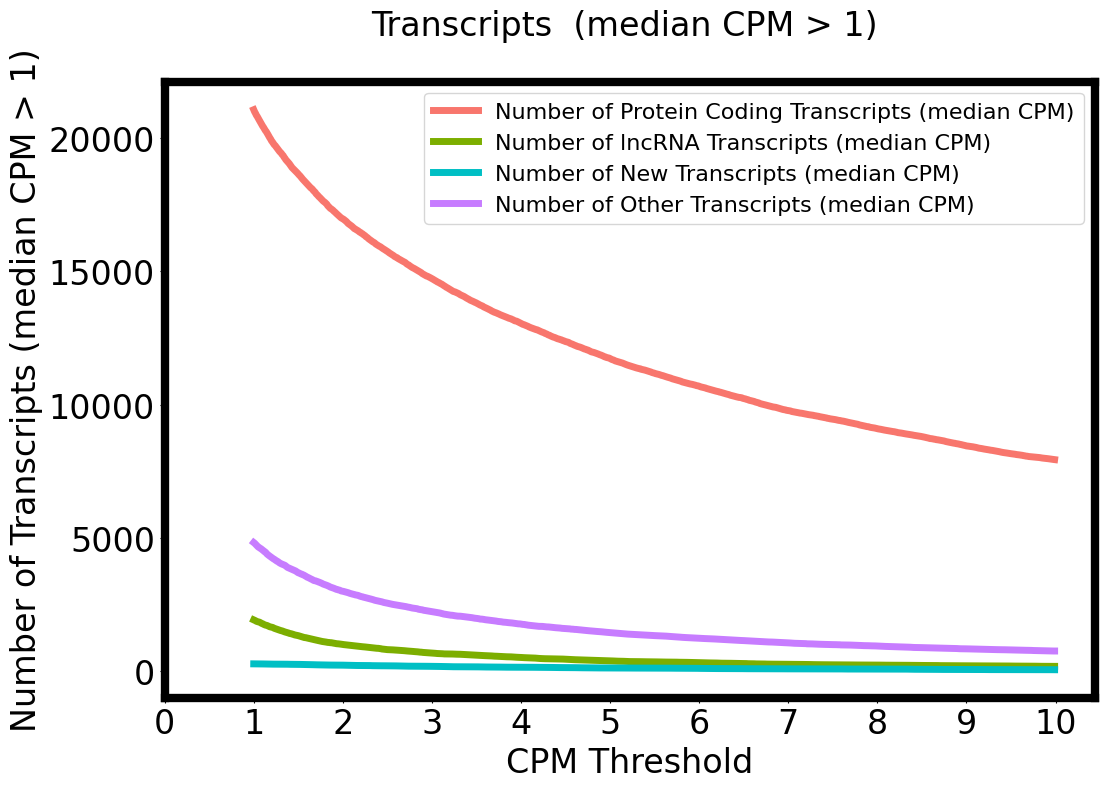

In [95]:
## Make plot showing number of transcripts across CPM thresholds with subtypes

plt.plot(list_cpm_thresh[100:], list_num_transcripts_median[0][100:], color=ggplot2_colors[0], label="Number of Protein Coding Transcripts (median CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_num_transcripts_median[1][100:], color=ggplot2_colors[2], label="Number of lncRNA Transcripts (median CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_num_transcripts_median[2][100:], color=ggplot2_colors[4], label="Number of New Transcripts (median CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh[100:], list_num_transcripts_median[3][100:], color=ggplot2_colors[6], label="Number of Other Transcripts (median CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts (median CPM > 1)')
plt.legend(loc="upper right", fontsize=16)
plt.title("Transcripts  (median CPM > 1) \n", fontsize=24)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/06/number_of_transcripts_across_cpm_thresh_subtypes_median_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/06/number_of_transcripts_across_cpm_thresh_subtypes_median_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [101]:
## Create list for stacked barplot for 3 different CPM Thresholds
list_stacked_barplot = [[], [], [], []]

for i in range(4):

    median_cpm_1 = list_num_transcripts_median[i][100]
    median_cpm_5 = list_num_transcripts_median[i][500]
    
    median_cpm_1_diff = median_cpm_1 - median_cpm_5
    
    list_stacked_barplot[i].append(median_cpm_1_diff)
    list_stacked_barplot[i].append(median_cpm_5)
    
## Make it into a dataframe
df_stacked_barplot = pd.DataFrame({'median CPM > 5': [list_stacked_barplot[0][1], list_stacked_barplot[1][1], 
                                                   list_stacked_barplot[2][1], list_stacked_barplot[3][1]],
    
                                    'median CPM > 1': [list_stacked_barplot[0][0], list_stacked_barplot[1][0], 
                                                   list_stacked_barplot[2][0], list_stacked_barplot[3][0]]},
                                  
                                  index=['Protein Coding', 'lncRNA', 'New Transcripts', 'Other Transcripts'])

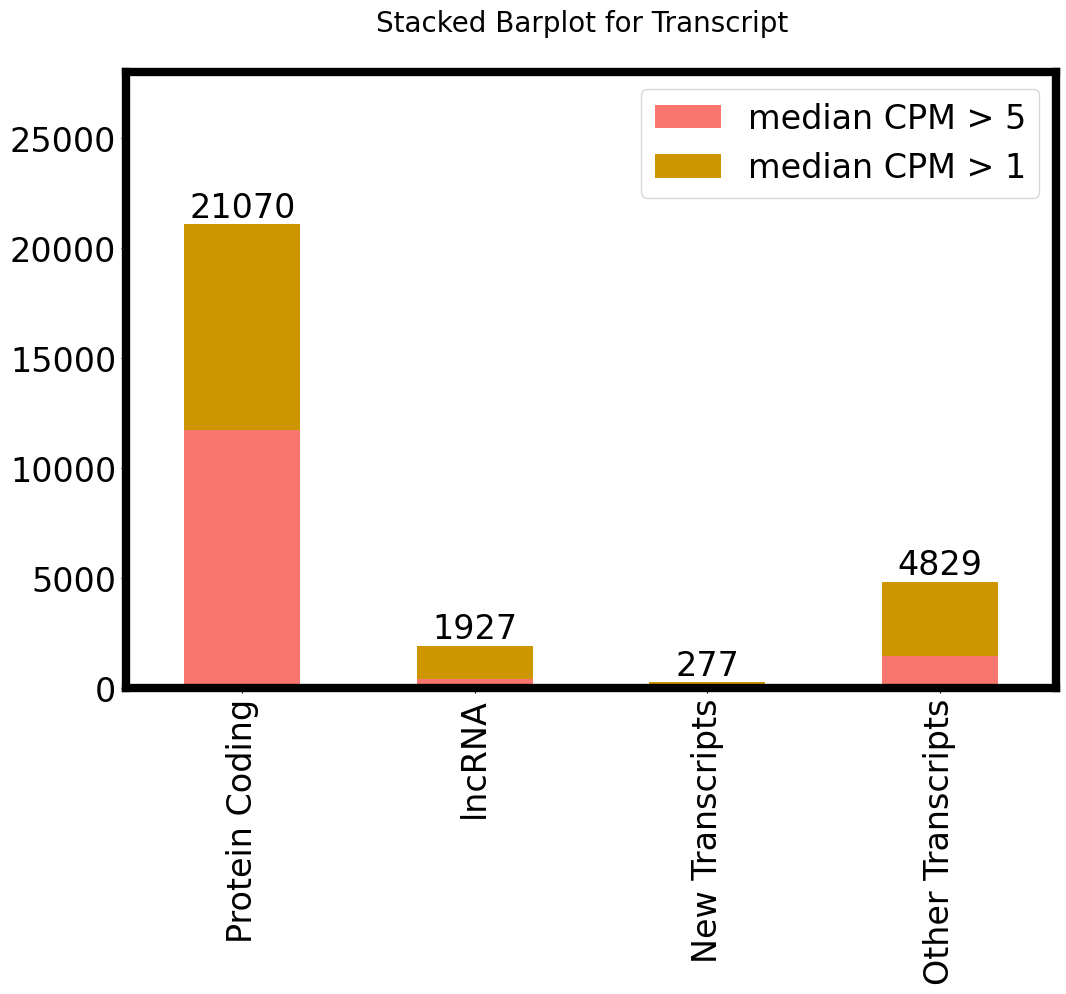

In [104]:
ax = df_stacked_barplot.plot(kind='bar' ,stacked=True, color=ggplot2_colors)

ax.bar_label(ax.containers[1])

plt.title("Stacked Barplot for Transcript  \n", fontsize=20)
ax.set(ylim=(0, 28000))

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/06/stacked_barplot_transcript_type_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/06/stacked_barplot_transcript_type_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [105]:
## Transcript diversity quantification, rank percentille of expression
df_transcript_diversity = df_general.copy()

df_transcript_expressed = df_transcript_diversity.loc[df_transcript_diversity["total_CPM"] > 0].copy()
df_transcript_cpm_1 = df_transcript_diversity.loc[df_transcript_diversity["total_CPM"] > 1].copy()


df_transcript_diversity['percentile'] = df_transcript_diversity["total_CPM"].rank(pct=True)
df_transcript_expressed['percentile'] = df_transcript_expressed["total_CPM"].rank(pct=True)
df_transcript_cpm_1['percentile'] = df_transcript_cpm_1["total_CPM"].rank(pct=True)

In [106]:
## Get CPM total
sum_CPM_total = df_transcript_diversity.loc[df_transcript_diversity["percentile"] <= 1]["total_CPM"].sum()
sum_CPM_total_expressed = df_transcript_expressed.loc[df_transcript_expressed["percentile"] <= 1]["total_CPM"].sum()
sum_CPM_total_cpm_1 = df_transcript_cpm_1.loc[df_transcript_cpm_1["percentile"] <= 1]["total_CPM"].sum()

In [107]:
## Get how much the top X percenile of transcripts takes up the total transcript expression
list_transcript_diversity = []
list_transcript_expressed = []
list_transcript_cpm_1 = []

list_percentile = []

for i in range (0, 1001):
    
    percentile = i/1000
    
    list_percentile.append((percentile*100))
    
    list_transcript_diversity.append(df_transcript_diversity.loc[
        df_transcript_diversity["percentile"] <= percentile]["total_CPM"].sum()/sum_CPM_total)
    
    list_transcript_expressed.append(df_transcript_expressed.loc[
        df_transcript_expressed["percentile"] <= percentile]["total_CPM"].sum()/sum_CPM_total)

    list_transcript_cpm_1.append(df_transcript_cpm_1.loc[
        df_transcript_cpm_1["percentile"] <= percentile]["total_CPM"].sum()/sum_CPM_total)


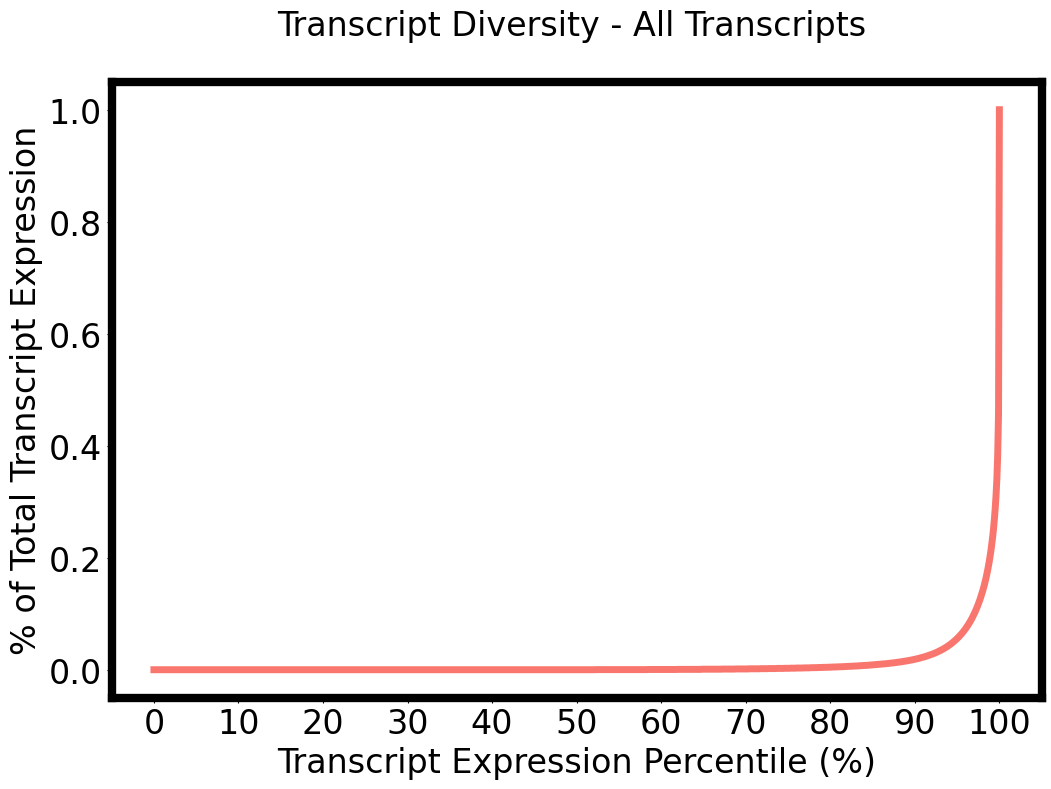

In [108]:
## Make plot showing number of transcripts across CPM thresholds with subtypes

plt.plot(list_percentile, list_transcript_diversity, color=ggplot2_colors[0], linewidth=5, alpha=1)

plt.xticks(np.arange(0, 101, 10))
plt.xlabel('Transcript Expression Percentile (%)')
plt.ylabel('% of Total Transcript Expression')
plt.title("Transcript Diversity - All Transcripts \n", fontsize=24)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/06/transcript_diversity_plot_all.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/06/transcript_diversity_plot_all.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

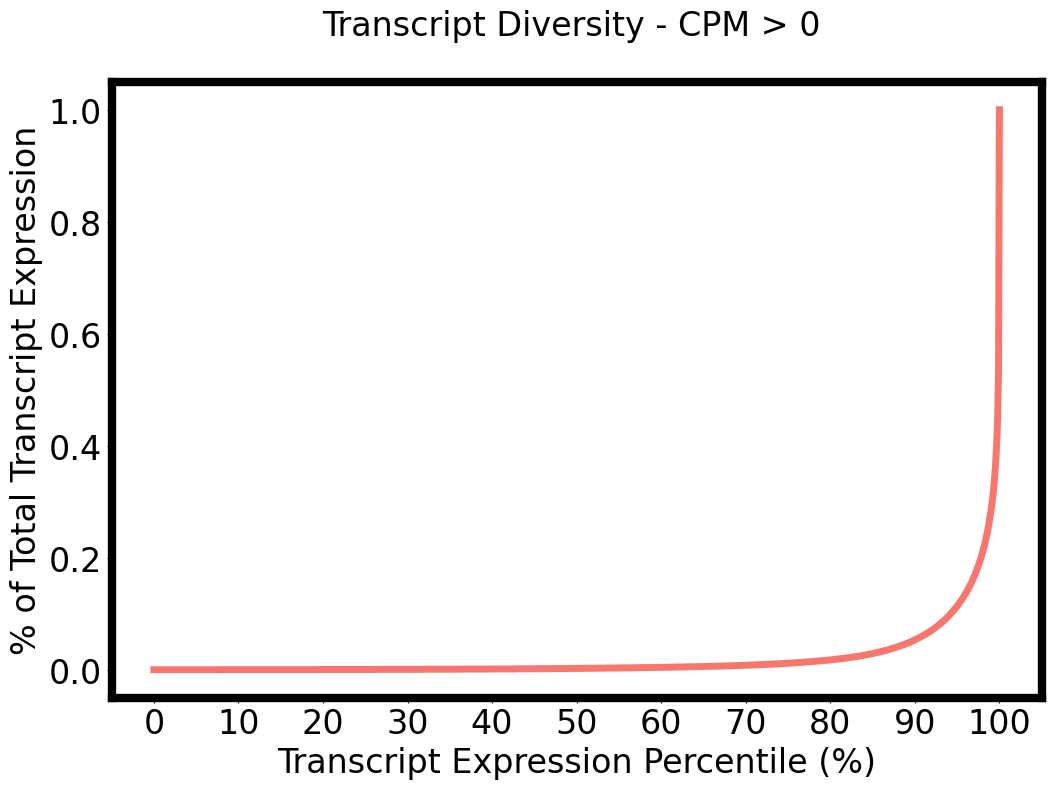

In [109]:
## Make plot showing number of transcripts across CPM thresholds with subtypes

plt.plot(list_percentile, list_transcript_expressed, color=ggplot2_colors[0], linewidth=5, alpha=1)

plt.xticks(np.arange(0, 101, 10))
plt.xlabel('Transcript Expression Percentile (%)')
plt.ylabel('% of Total Transcript Expression')
plt.title("Transcript Diversity - CPM > 0 \n", fontsize=24)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/06/transcript_diversity_plot_all_cpm_above_0.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/06/transcript_diversity_plot_all_cpm_above_0.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

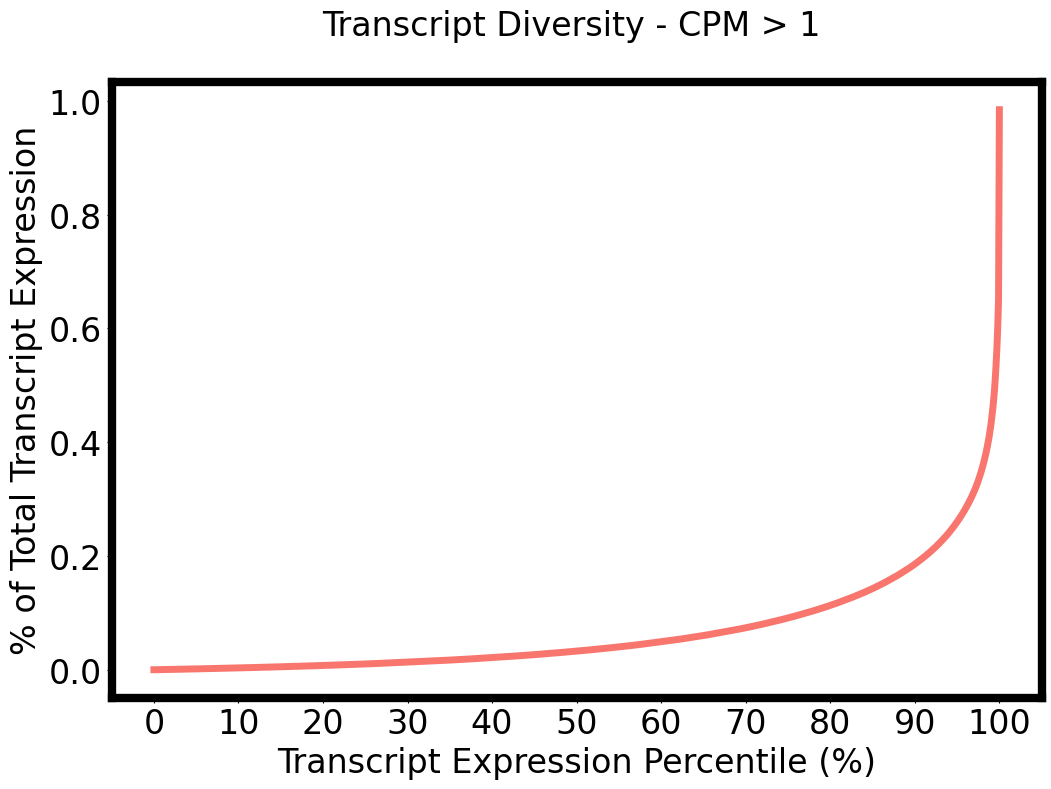

In [110]:
## Make plot showing number of transcripts across CPM thresholds with subtypes

plt.plot(list_percentile, list_transcript_cpm_1, color=ggplot2_colors[0], linewidth=5, alpha=1)

plt.xticks(np.arange(0, 101, 10))
plt.xlabel('Transcript Expression Percentile (%)')
plt.ylabel('% of Total Transcript Expression')
plt.title("Transcript Diversity - CPM > 1 \n", fontsize=24)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/06/transcript_diversity_plot_all_cpm_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/06/transcript_diversity_plot_all_cpm_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

# 7) Quantification of Novel transcripts

In [111]:
## Create dataframe with only novel transcripts
df_novel = df_general.loc[df_general["transcript_id"].str.startswith("BambuTx")].copy()

In [113]:
## Create lists with number of novel genes and transcripts across CPM thresholds
list_cpm_thresh = []

list_num_new_transcripts_annotated_gene_median = []
list_num_new_transcripts_new_gene_median = []
list_num_new_transcript_median = []


for i in range(0, 1000):
    
    cpm_thresh = i/100
    cpm_cols = df_general.columns[2:]
    
    new_transcripts_annotated_gene_median_num = df_novel_transcripts.loc[df_novel_transcripts["median_CPM"] >= cpm_thresh].shape[0]
    
    new_transcripts_new_gene_median_num = df_novel_genes.loc[df_novel_genes["median_CPM"] >= cpm_thresh].shape[0]
    
    new_transcripts_median = df_novel.loc[df_novel["median_CPM"] >= cpm_thresh].shape[0]
    
    list_cpm_thresh.append(cpm_thresh)
    
    list_num_new_transcripts_annotated_gene_median.append(new_transcripts_annotated_gene_median_num)
    
    list_num_new_transcripts_new_gene_median.append(new_transcripts_new_gene_median_num)
    
    list_num_new_transcript_median.append(new_transcripts_median)

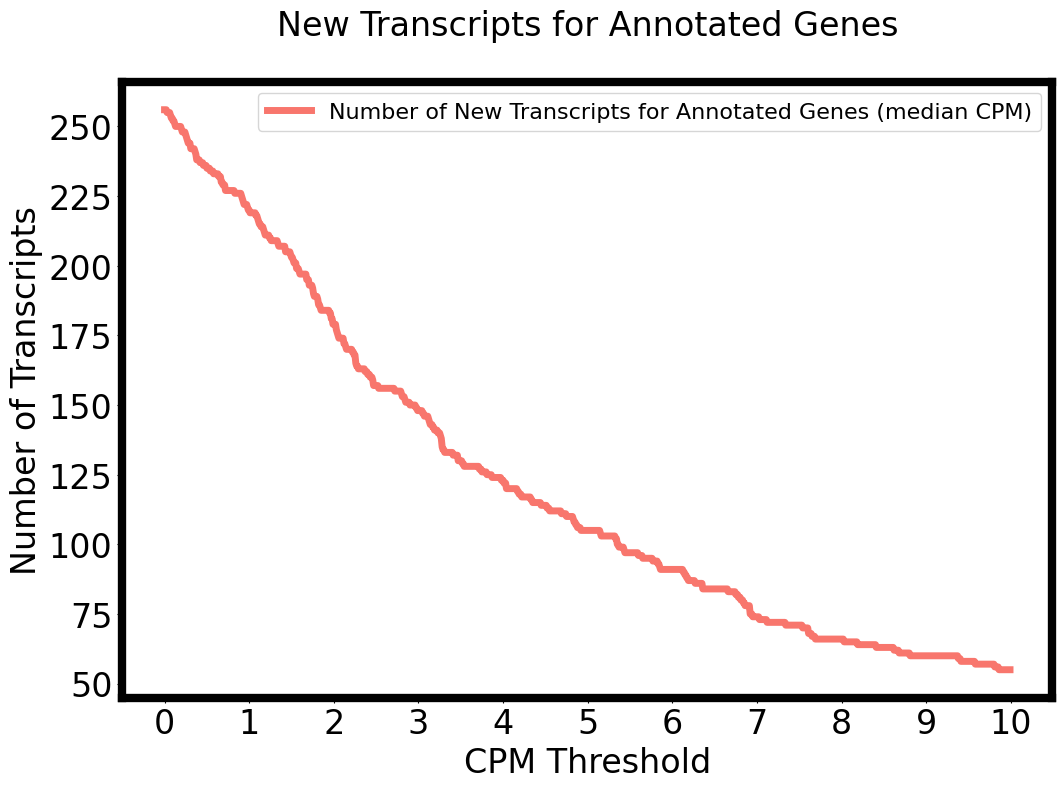

In [114]:
## Make plot showing number of new transcripts for annotated genes across CPM thresholds


plt.plot(list_cpm_thresh, list_num_new_transcripts_annotated_gene_median, color=ggplot2_colors[0], label="Number of New Transcripts for Annotated Genes (median CPM)", linewidth=5, alpha=1)


plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("New Transcripts for Annotated Genes\n", fontsize=24)

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/07/number_of_novel_transcripts_for_annotated_genes_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/07/number_of_novel_transcripts_for_annotated_genes_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

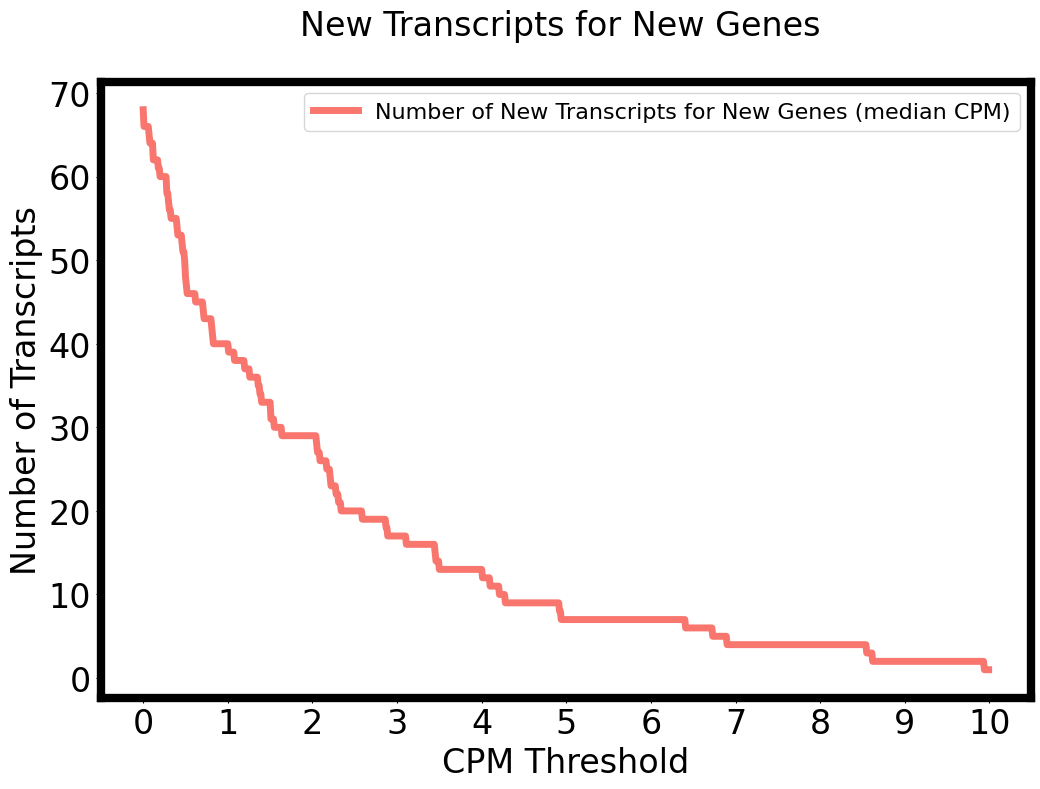

In [115]:
## Make plot showing number of new transcripts for new genes across CPM thresholds

plt.plot(list_cpm_thresh, list_num_new_transcripts_new_gene_median, color=ggplot2_colors[0], label="Number of New Transcripts for New Genes (median CPM)", linewidth=5, alpha=1)


plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("New Transcripts for New Genes \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/07/number_of_novel_transcripts_for_new_genes_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/07/number_of_novel_transcripts_for_new_genes_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

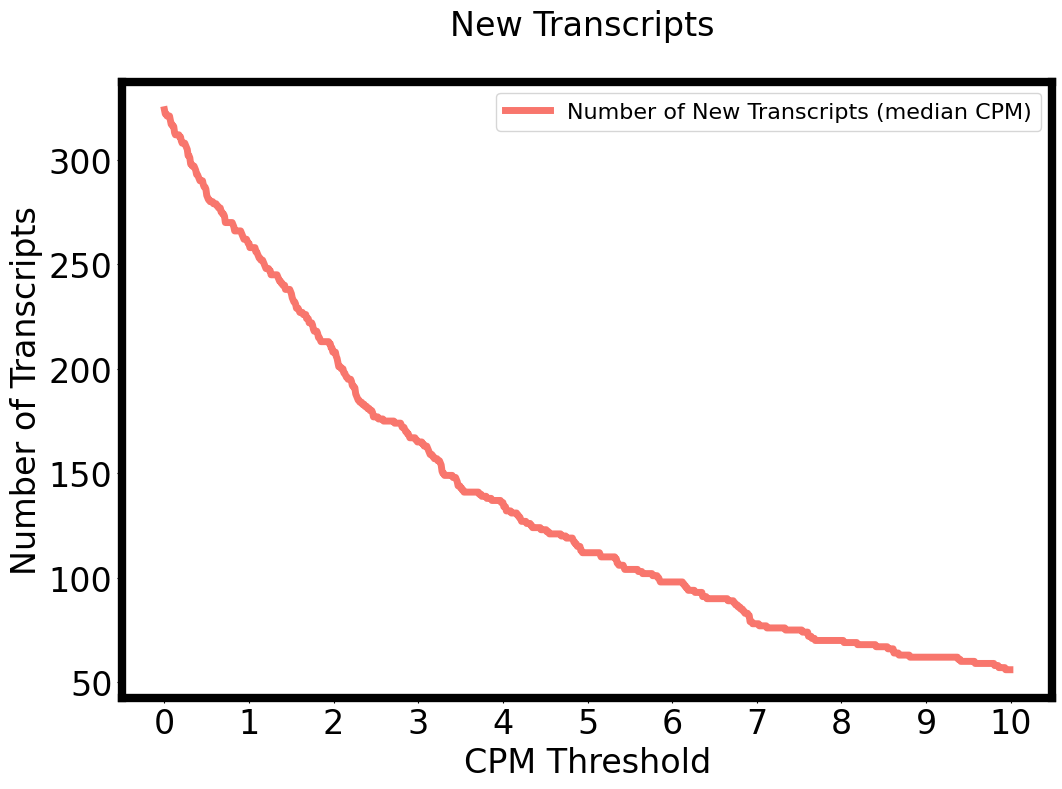

In [116]:
## Make plot showing number of new transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_num_new_transcript_median, color=ggplot2_colors[0], label="Number of New Transcripts (median CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("New Transcripts \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/07/number_of_novel_transcripts_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/07/number_of_novel_transcripts_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

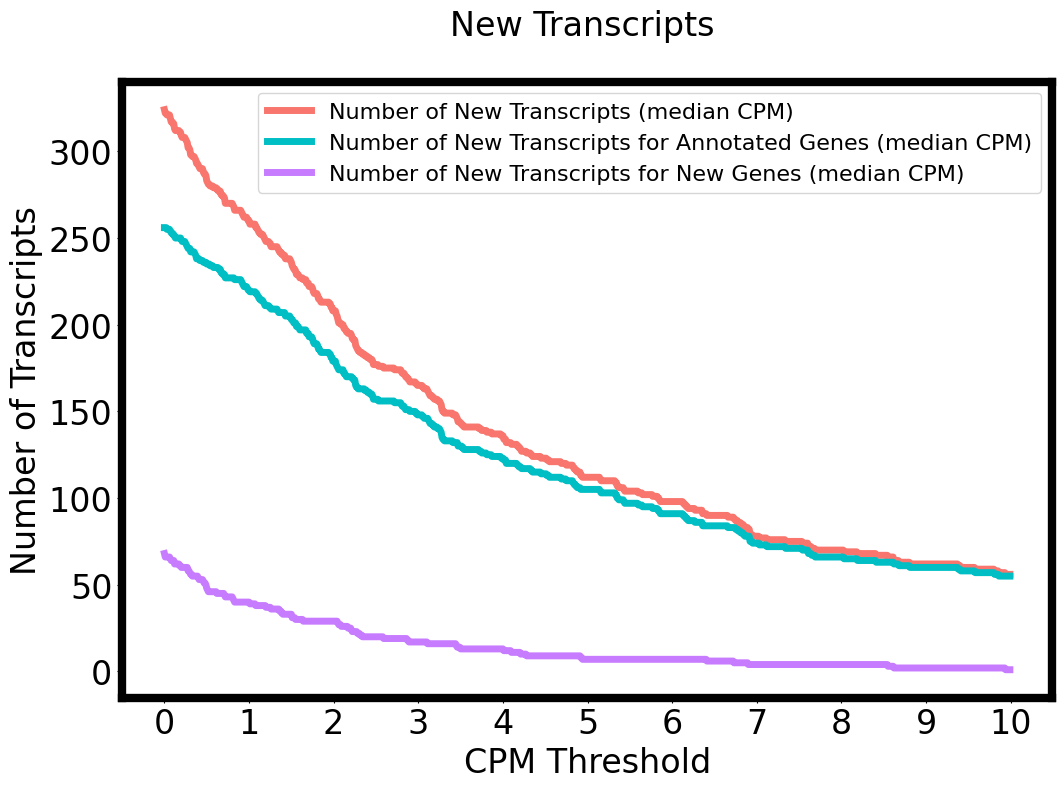

In [117]:
## Make plot showing everything for new transcripts for new genes across CPM thresholds

plt.plot(list_cpm_thresh, list_num_new_transcript_median, color=ggplot2_colors[0], label="Number of New Transcripts (median CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_new_transcripts_annotated_gene_median, color=ggplot2_colors[4], label="Number of New Transcripts for Annotated Genes (median CPM)", linewidth=5, alpha=1)

plt.plot(list_cpm_thresh, list_num_new_transcripts_new_gene_median, color=ggplot2_colors[6], label="Number of New Transcripts for New Genes (median CPM)", linewidth=5, alpha=1)


plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("New Transcripts \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/07/number_of_novel_transcripts_all_combined_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/07/number_of_novel_transcripts_all_combined_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [119]:
## Create list for stacked barplot for 3 different CPM Thresholds for new transcripts
list_stacked_barplot = [[], [], [], []]

list_num_new_transcripts_median = [list_num_new_transcript_median, list_num_new_transcripts_annotated_gene_median, 
                                list_num_new_transcripts_new_gene_median]


for i in range(3):

    median_cpm_1 = list_num_new_transcripts_median[i][100]
    median_cpm_5 = list_num_new_transcripts_median[i][500]
    
    median_cpm_1_diff = median_cpm_1 - median_cpm_5
    
    list_stacked_barplot[i].append(median_cpm_1_diff)
    list_stacked_barplot[i].append(median_cpm_5)
    
## Make it into a dataframe
df_stacked_barplot = pd.DataFrame({'median CPM > 5': [list_stacked_barplot[0][1], list_stacked_barplot[1][1], 
                                                   list_stacked_barplot[2][1]],
    
                                    'median CPM > 1': [list_stacked_barplot[0][0], list_stacked_barplot[1][0], 
                                                   list_stacked_barplot[2][0]]},
                                  
                                  index=['New Tx - All', 'New Tx - Known Gene', 
                                         'New Tx - New Gene'])

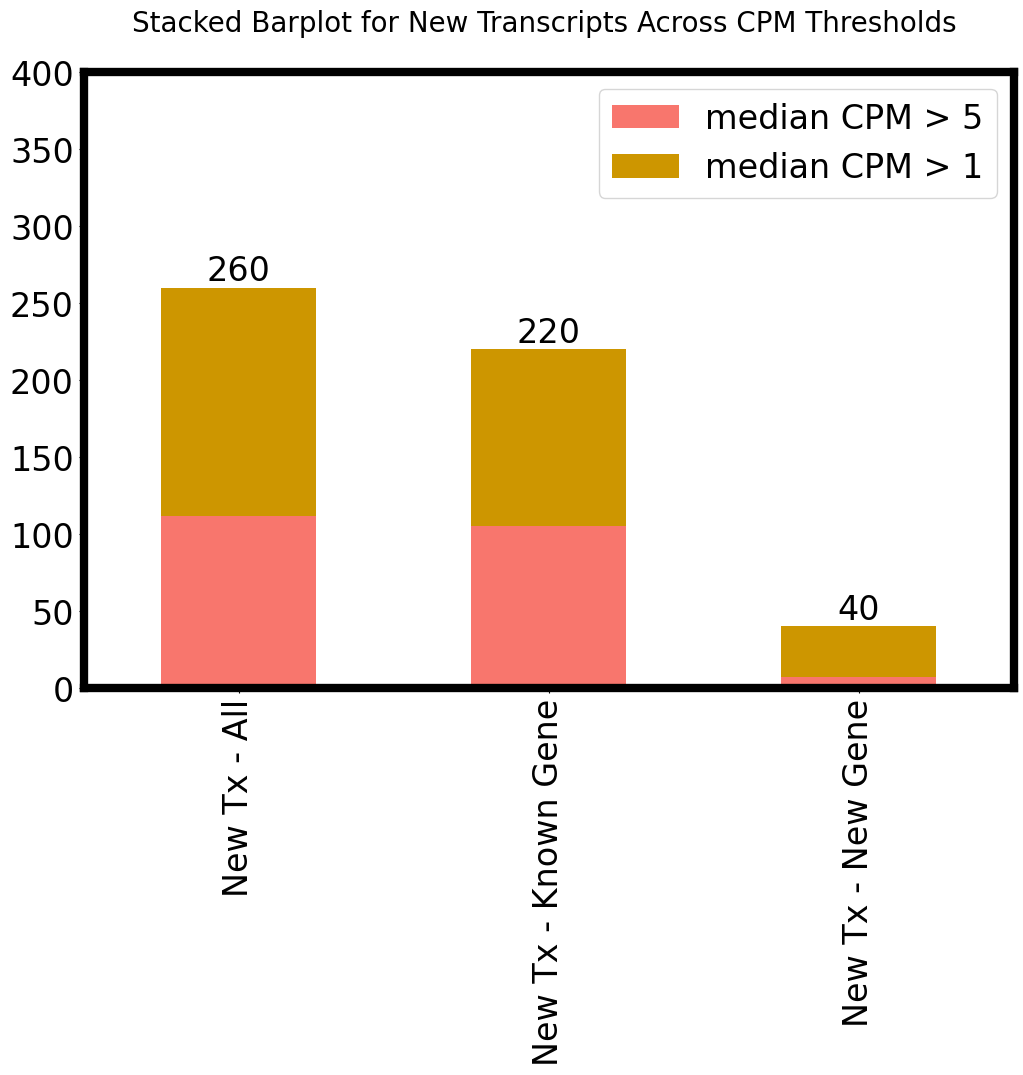

In [122]:
ax = df_stacked_barplot.plot(kind='bar' ,stacked=True, color=ggplot2_colors)

ax.bar_label(ax.containers[1])

plt.title("Stacked Barplot for New Transcripts Across CPM Thresholds \n", fontsize=20)
ax.set(ylim=(0, 400))

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/07/stacked_barplot_new_transcripts_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/07/stacked_barplot_new_transcripts_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

# 8) Quantification of Protein Coding

## 8A) Protein Coding Genes

In [123]:
## Make transcript_protein_coding_ref
orig_ref_prot_gene = original_ref.loc[original_ref["type"]=="gene"].copy()
orig_ref_prot_gene = parse_df_columns(orig_ref_prot_gene, is_ref=True, is_transcript=False)
orig_ref_prot_gene = orig_ref_prot_gene.loc[orig_ref_prot_gene["gene_biotype"] == "protein_coding"]

In [124]:
## Only keep protein coding transcript in count matrix
df_protein_gene = df_general.loc[df_general["gene_id"].isin(orig_ref_prot_gene["gene_id"])].copy()

In [125]:
## Create lists with number of protein coding transcripts across CPM thresholds
list_cpm_thresh = []

list_prot_gene_transcripts_median = []

list_prot_gene_genes_median = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    cpm_cols = df_general.columns[2:]
    
    prot_gene_transcripts_median_num = df_protein_gene.loc[df_protein_gene["median_CPM"] >= cpm_thresh].shape[0]
    
    prot_gene_genes_median_num = df_protein_gene.loc[df_protein_gene["median_CPM"] >= cpm_thresh]["gene_id"].nunique()
    
    list_cpm_thresh.append(cpm_thresh)
    
    list_prot_gene_transcripts_median.append(prot_gene_transcripts_median_num)
    list_prot_gene_genes_median.append(prot_gene_genes_median_num)


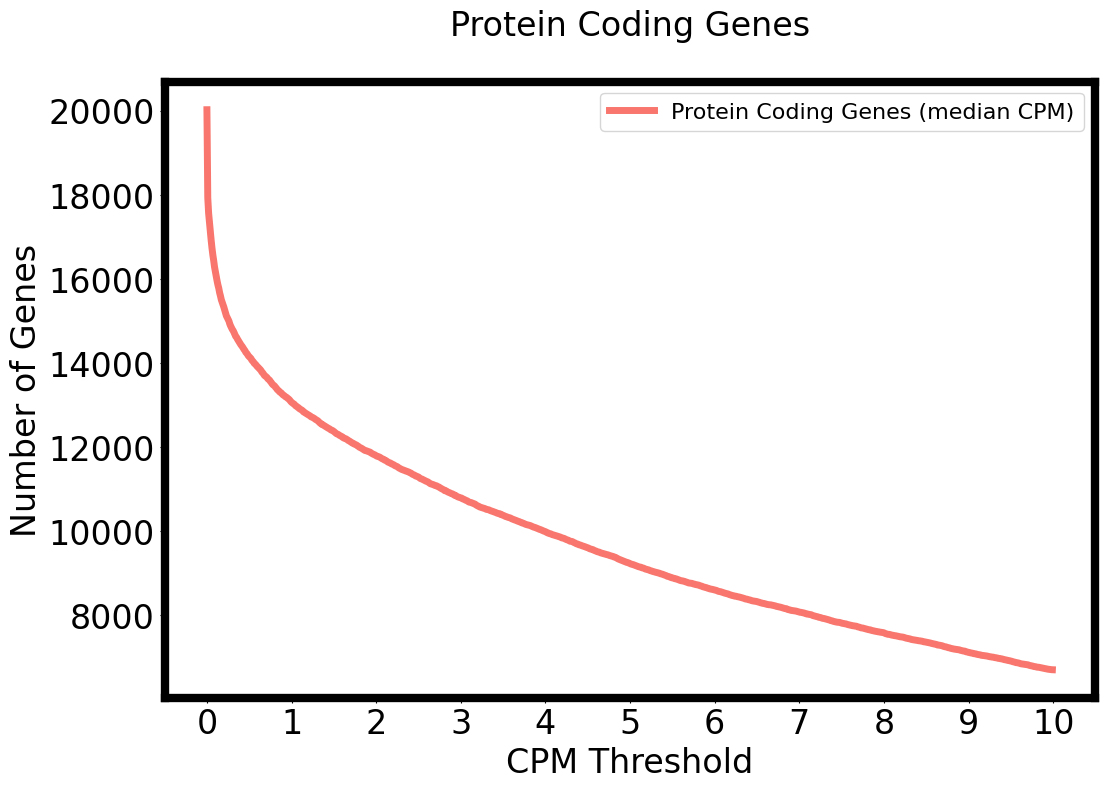

In [126]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_prot_gene_genes_median, color=ggplot2_colors[0], label="Protein Coding Genes (median CPM)", linewidth=5, alpha=1)


plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("Protein Coding Genes\n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08A/number_of_protein_coding_genes_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08A/number_of_protein_coding_genes_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

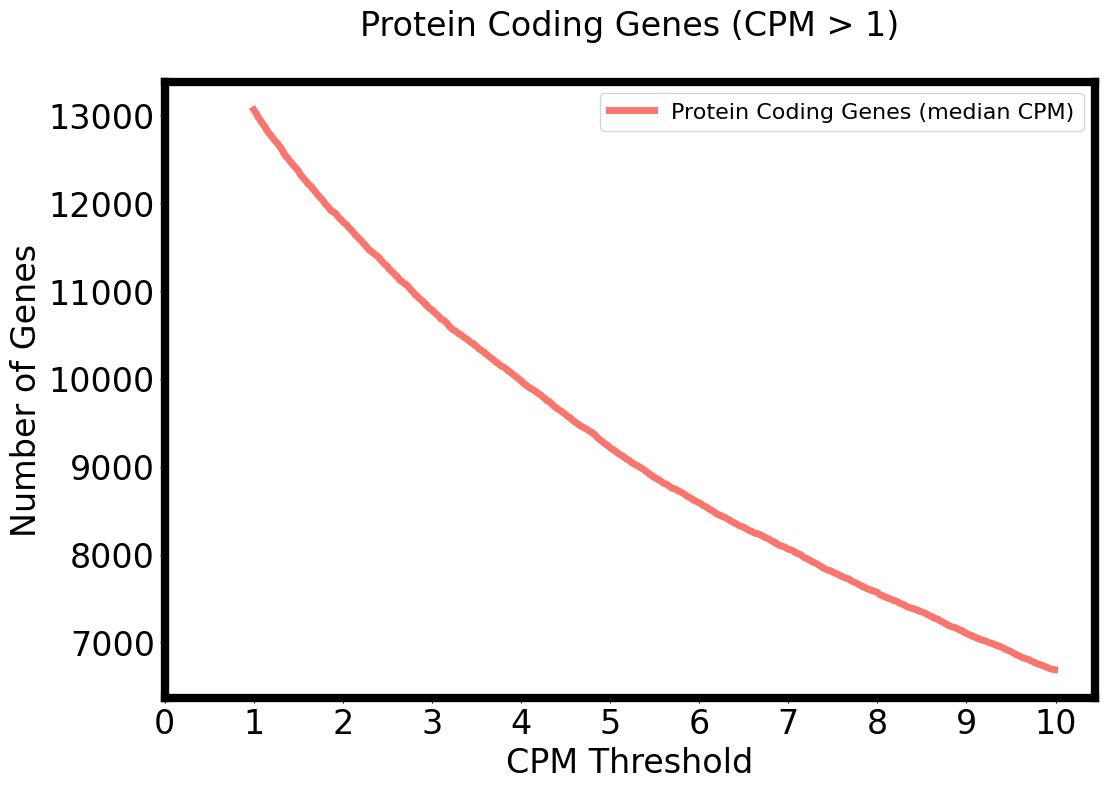

In [128]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh[100:], list_prot_gene_genes_median[100:], color=ggplot2_colors[0], label="Protein Coding Genes (median CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("Protein Coding Genes (CPM > 1)\n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08A/number_of_protein_coding_genes_across_cpm_thresh_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08A/number_of_protein_coding_genes_across_cpm_thresh_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

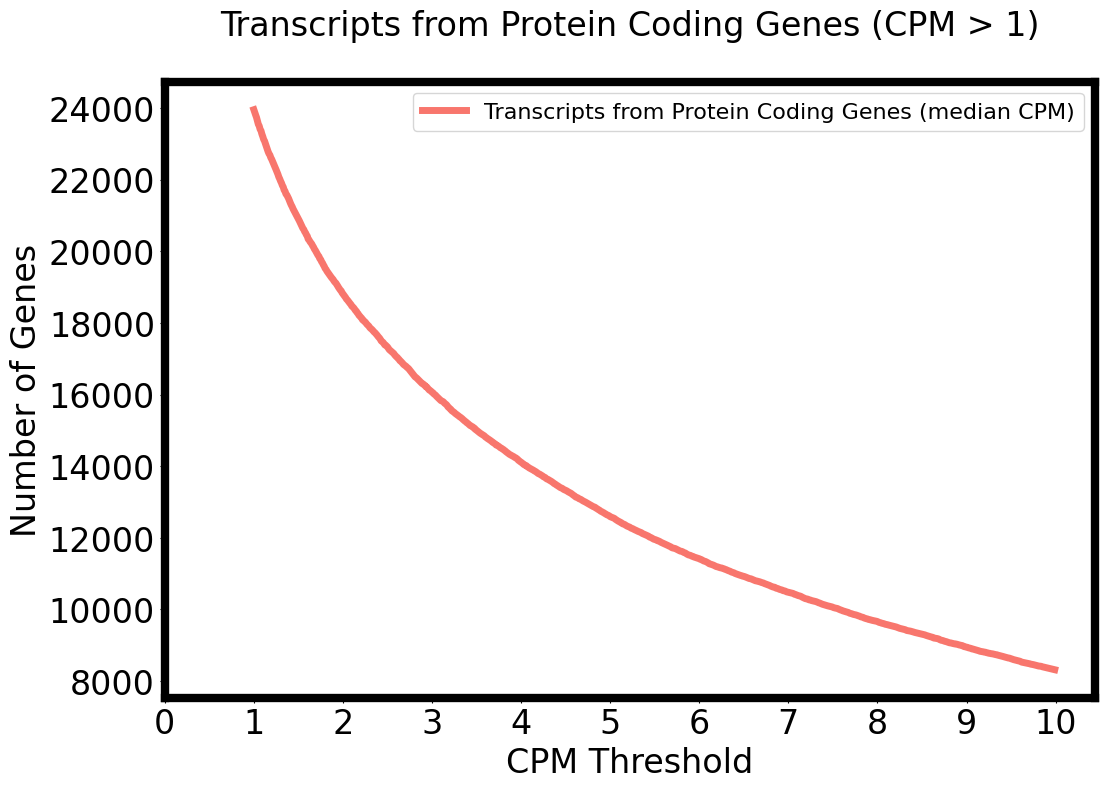

In [129]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh[100:], list_prot_gene_transcripts_median[100:], color=ggplot2_colors[0], label="Transcripts from Protein Coding Genes (median CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("Transcripts from Protein Coding Genes (CPM > 1)\n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08A/number_of_protein_coding_gene_transcripts_across_cpm_thresh_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08A/number_of_protein_coding_gene_transcripts_across_cpm_thresh_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [130]:
## Create lists with number of protein coding transcripts across CPM thresholds
list_cpm_thresh = []


list_prot_genes_multiple_transcripts_median = []


for i in range(0, 1000):
    
    cpm_thresh = i/100
    cpm_cols = df_general.columns[2:]
   
    df_prot_gene_median_multiple_iso = df_protein_gene.loc[df_protein_gene["total_CPM"] >= cpm_thresh].copy()
    
    df_prot_gene_median_multiple_iso = df_prot_gene_median_multiple_iso.loc[df_prot_gene_median_multiple_iso.duplicated(subset="gene_id", keep=False)]
    
    num_prot_genes_muiltiple_isoform_median = df_prot_gene_median_multiple_iso["gene_id"].nunique()

    
    list_cpm_thresh.append(cpm_thresh)
    
    list_prot_genes_multiple_transcripts_median.append(num_prot_genes_muiltiple_isoform_median)

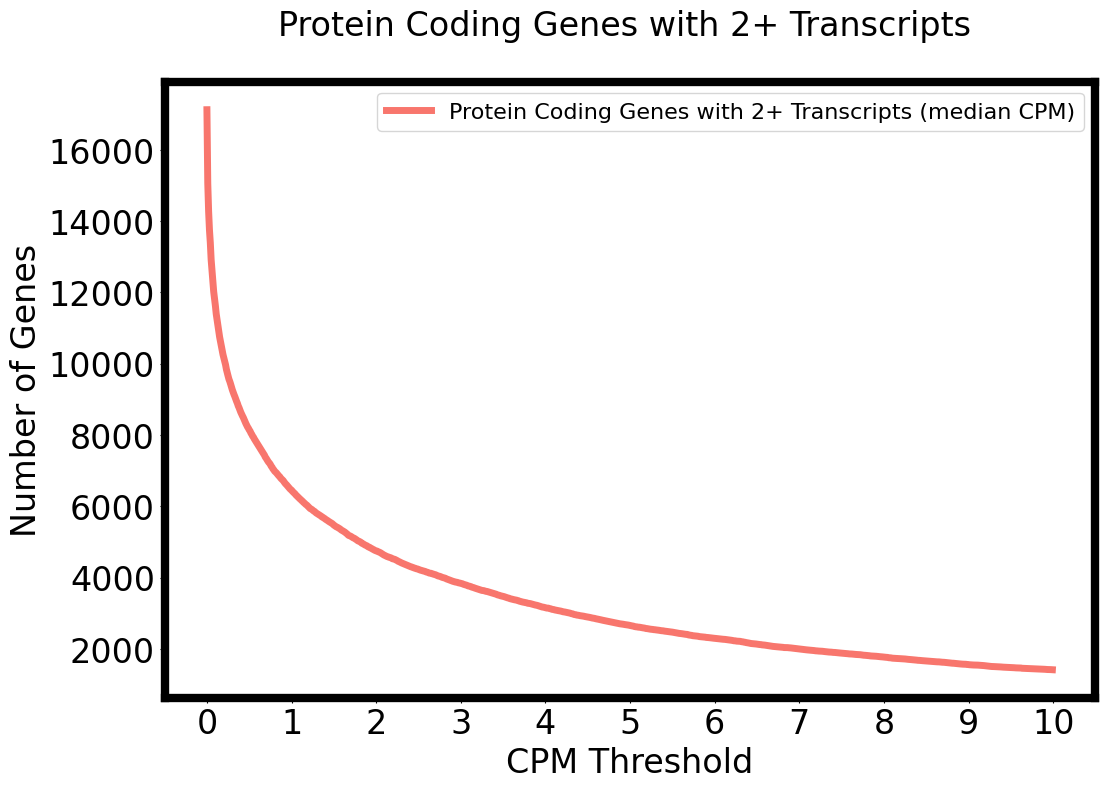

In [131]:
## Make plot showing number of protein coding genes with multiple expressed isoforms across CPM thresh

plt.plot(list_cpm_thresh, list_prot_genes_multiple_transcripts_median, color=ggplot2_colors[0], label="Protein Coding Genes with 2+ Transcripts (median CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("Protein Coding Genes with 2+ Transcripts \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08A/number_of_protein_coding_genes_with_multiple_isoforms_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08A/number_of_protein_coding_genes_with_multiple_isoforms_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

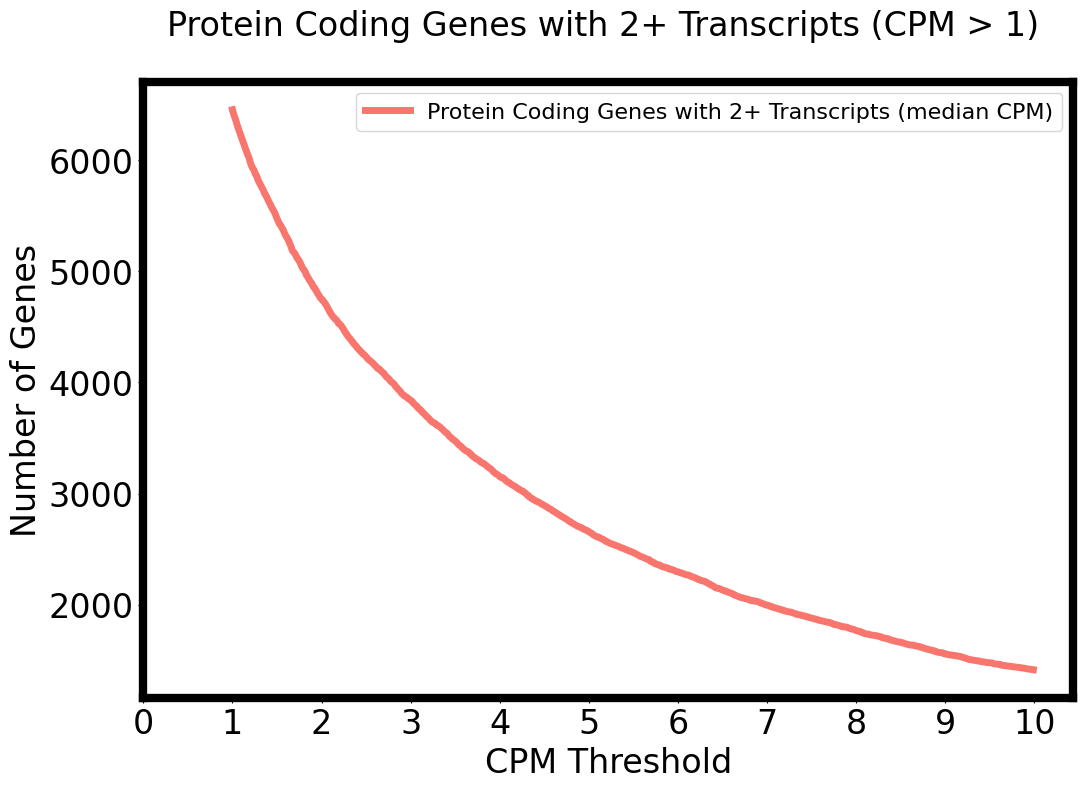

In [132]:
## Make plot showing number of protein coding genes with multiple expressed isoforms across CPM thresh

plt.plot(list_cpm_thresh[100:], list_prot_genes_multiple_transcripts_median[100:], color=ggplot2_colors[0], label="Protein Coding Genes with 2+ Transcripts (median CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("Protein Coding Genes with 2+ Transcripts (CPM > 1) \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08A/number_of_protein_coding_genes_with_multiple_isoforms_across_cpm_thresh_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08A/number_of_protein_coding_genes_with_multiple_isoforms_across_cpm_thresh_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [133]:
## Create CPM 5 Threhold multiple isoform filter

df_prot_median_multiple_iso = df_protein_gene.loc[df_protein_gene["total_CPM"] >= cpm_thresh].copy()

df_prot_median_multiple_iso = df_prot_median_multiple_iso.loc[df_prot_median_multiple_iso.duplicated(subset="gene_id", keep=False)]

## Get number of genes with multiple isoforms
df_numbers_prot_multiple_isoforms_median = df_prot_median_multiple_iso["gene_id"].value_counts()


In [135]:
## Get numbers of genes with multiple CPM > 5 protein coding isoforms for both filters

df_num_isoforms_prot_median = pd.DataFrame()
df_num_isoforms_prot_median["Number of Protein Coding Genes"] = df_numbers_prot_multiple_isoforms_median.value_counts()
df_num_isoforms_prot_median["Number of  Transcripts"] = df_numbers_prot_multiple_isoforms_median.value_counts().index

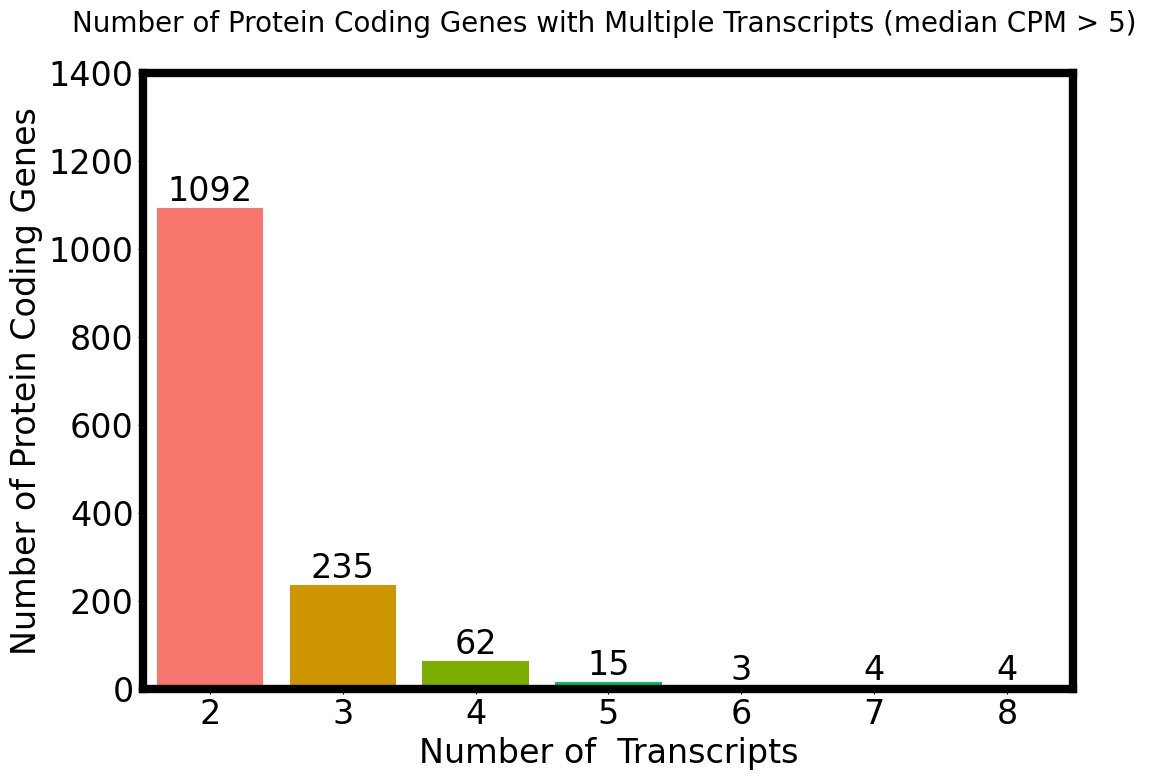

In [136]:
## Create and save graph showing number of protein coding genes with multiple isoforms (median CPM > 5)

ax = sns.barplot(data=df_num_isoforms_prot_median, y="Number of Protein Coding Genes", x="Number of  Transcripts",
            palette=ggplot2_colors, saturation=1)

ax.bar_label(ax.containers[0])
plt.title("Number of Protein Coding Genes with Multiple Transcripts (median CPM > 5) \n", fontsize=20)
ax.set(ylim=(0, 1400))

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08A/protein_coding_genes_with_multiple_transcripts_median_cpm_5.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08A/protein_coding_genes_genes_with_transcripts_median_cpm_5.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

## 8B) Protein Coding Transcripts

In [137]:
## Make transcript_protein_coding_ref
orig_ref_prot = original_ref.loc[original_ref["type"]=="transcript"].copy()
orig_ref_prot = parse_df_columns(orig_ref_prot, is_ref=True, is_transcript=True)
orig_ref_prot = orig_ref_prot.loc[orig_ref_prot["transcript_biotype"] == "protein_coding"]

In [138]:
## Only keep protein coding transcript in count matrix
protein_count = df_general.loc[df_general["transcript_id"].isin(orig_ref_prot["transcript_id"])].copy()

In [141]:
## Create lists with number of protein coding transcripts across CPM thresholds
list_cpm_thresh = []

list_prot_median = []
list_prot_genes_median = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    cpm_cols = df_general.columns[2:]
    
    prot_median_num = protein_count.loc[protein_count["median_CPM"] >= cpm_thresh].shape[0]
    
    prot_genes_median_num = protein_count.loc[protein_count["median_CPM"] >= cpm_thresh]["gene_id"].nunique()
    
    list_cpm_thresh.append(cpm_thresh)
    
    list_prot_median.append(prot_median_num)
    
    list_prot_genes_median.append(prot_genes_median_num)

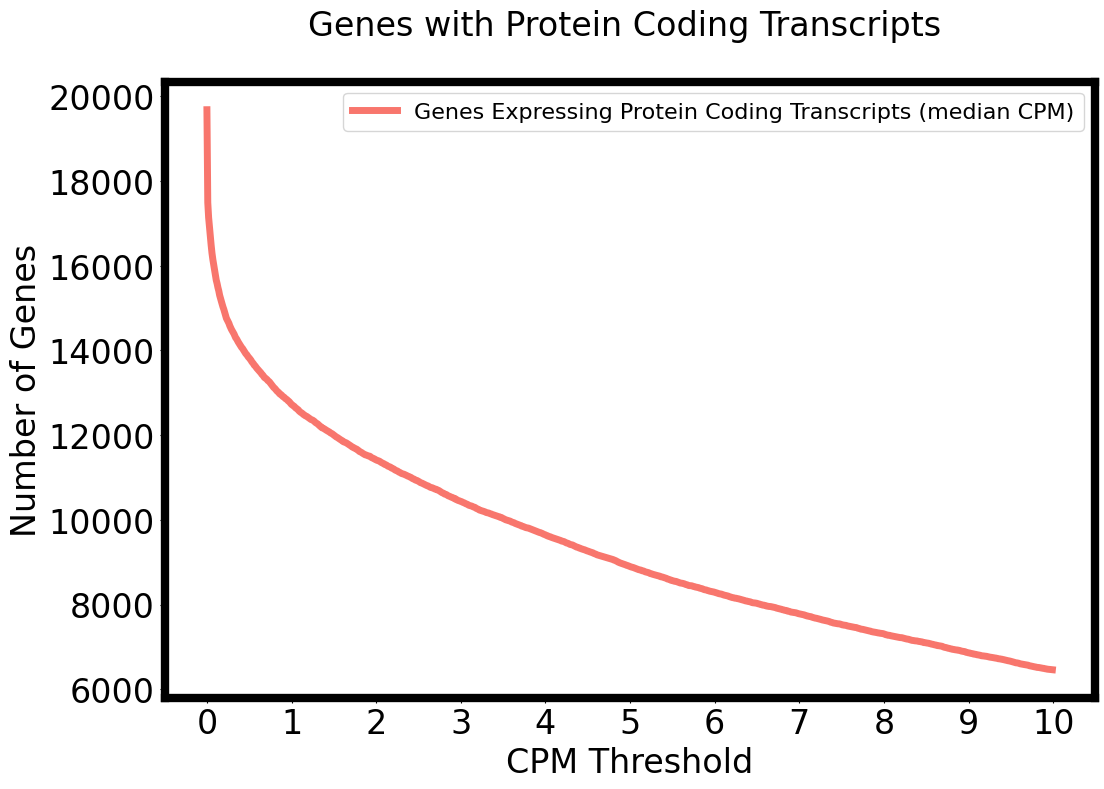

In [142]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_prot_genes_median, color=ggplot2_colors[0], label="Genes Expressing Protein Coding Transcripts (median CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("Genes with Protein Coding Transcripts \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08B/number_of_genes_with_protein_coding_transcripts_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08B/number_of_genes_with_protein_coding_transcripts_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

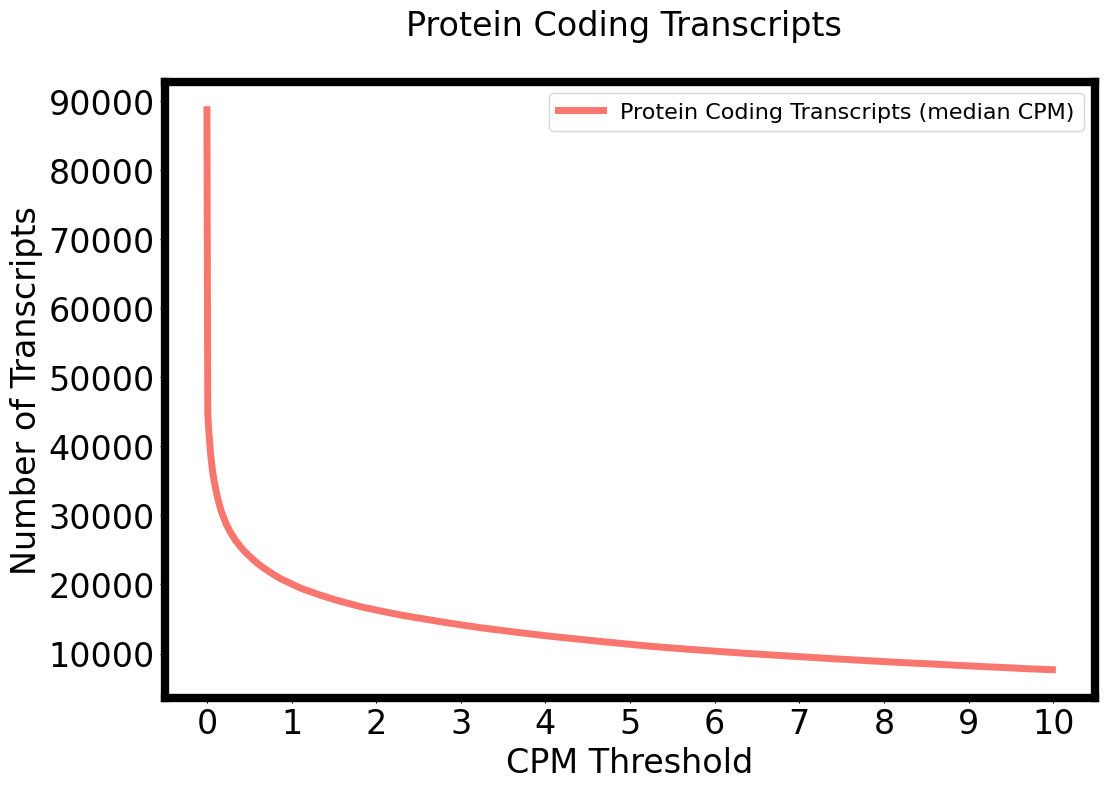

In [143]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_prot_median, color=ggplot2_colors[0], label="Protein Coding Transcripts (median CPM)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Protein Coding Transcripts \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08B/number_of_protein_coding_transcripts_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08B/number_of_protein_coding_transcripts_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

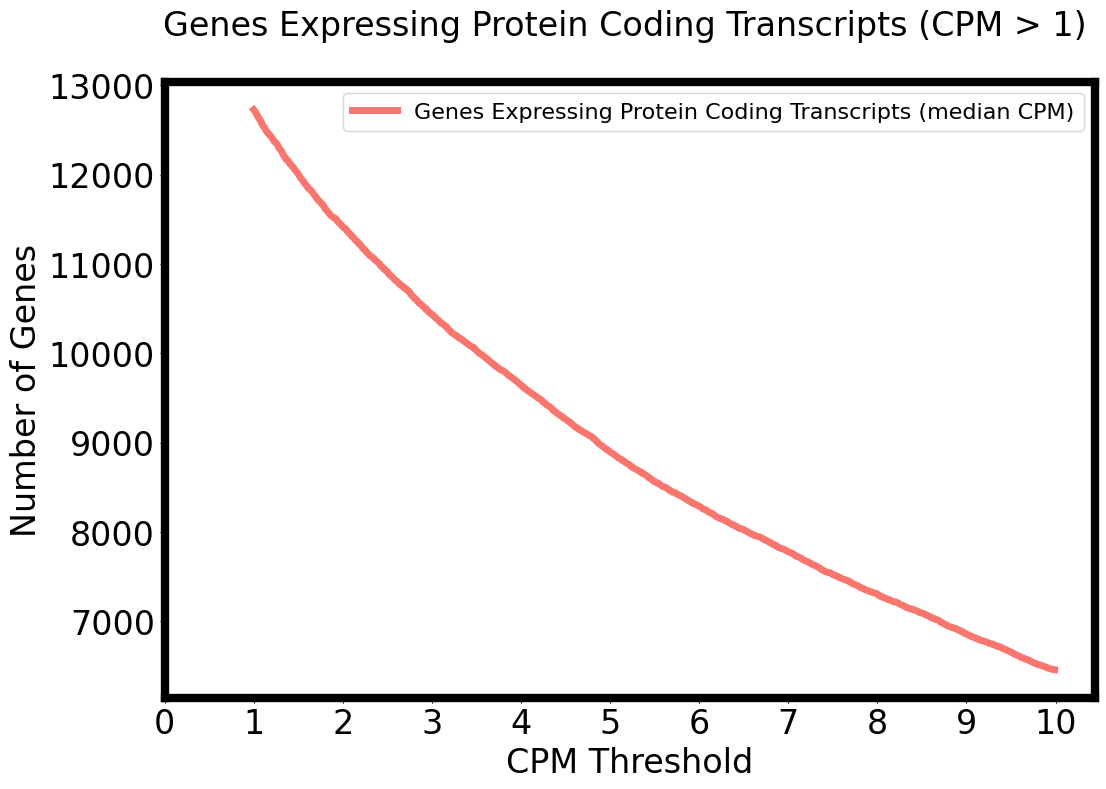

In [144]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh[100:], list_prot_genes_median[100:], color=ggplot2_colors[0], label="Genes Expressing Protein Coding Transcripts (median CPM)", linewidth=5, alpha=1)


plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("Genes Expressing Protein Coding Transcripts (CPM > 1) \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08B/number_of_genes_with_protein_coding_transcripts_across_cpm_thresh_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08B/number_of_genes_with_protein_coding_transcripts_across_cpm_thresh_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

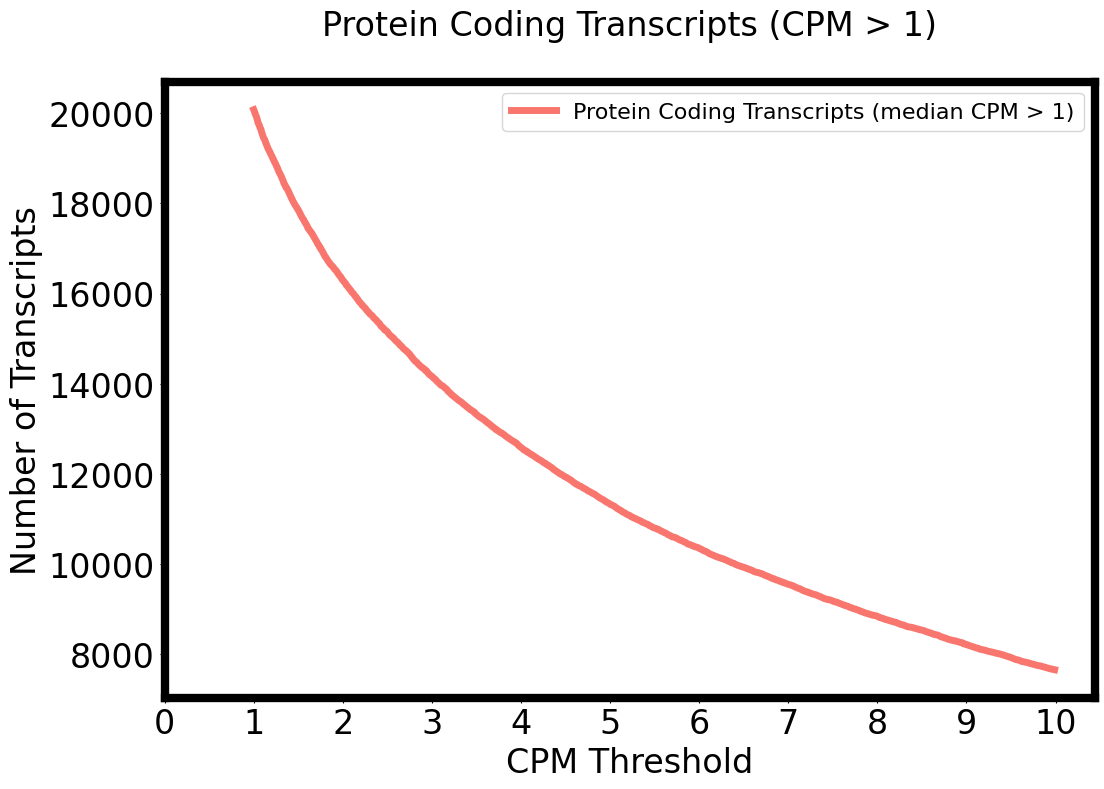

In [145]:
## Make plot showing number of protein coding transcripts across CPM thresholds

plt.plot(list_cpm_thresh[100:], list_prot_median[100:], color=ggplot2_colors[0], label="Protein Coding Transcripts (median CPM > 1)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Protein Coding Transcripts (CPM > 1)\n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08B/number_of_protein_coding_transcripts_across_cpm_thresh_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08B/number_of_protein_coding_transcripts_across_cpm_thresh_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [147]:
## Create lists with number of protein coding transcripts across CPM thresholds
list_cpm_thresh = []

list_prot_multiple_isoforms_median = []
list_genes_multiple_prot_isoforms_median = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    cpm_cols = df_general.columns[2:]
   
    df_prot_median_multiple_iso = protein_count.loc[protein_count["median_CPM"] >= cpm_thresh].copy()
    
    df_prot_median_multiple_iso = df_prot_median_multiple_iso.loc[df_prot_median_multiple_iso.duplicated(subset="gene_id", keep=False)]

    num_muiltiple_isoform_prot_median = df_prot_median_multiple_iso.shape[0]
    
    num_genes_muiltiple_isoform_prot_median = df_prot_median_multiple_iso["gene_id"].nunique()

    
    list_cpm_thresh.append(cpm_thresh)
    
    list_prot_multiple_isoforms_median.append(num_muiltiple_isoform_prot_median)
    
    list_genes_multiple_prot_isoforms_median.append(num_genes_muiltiple_isoform_prot_median)


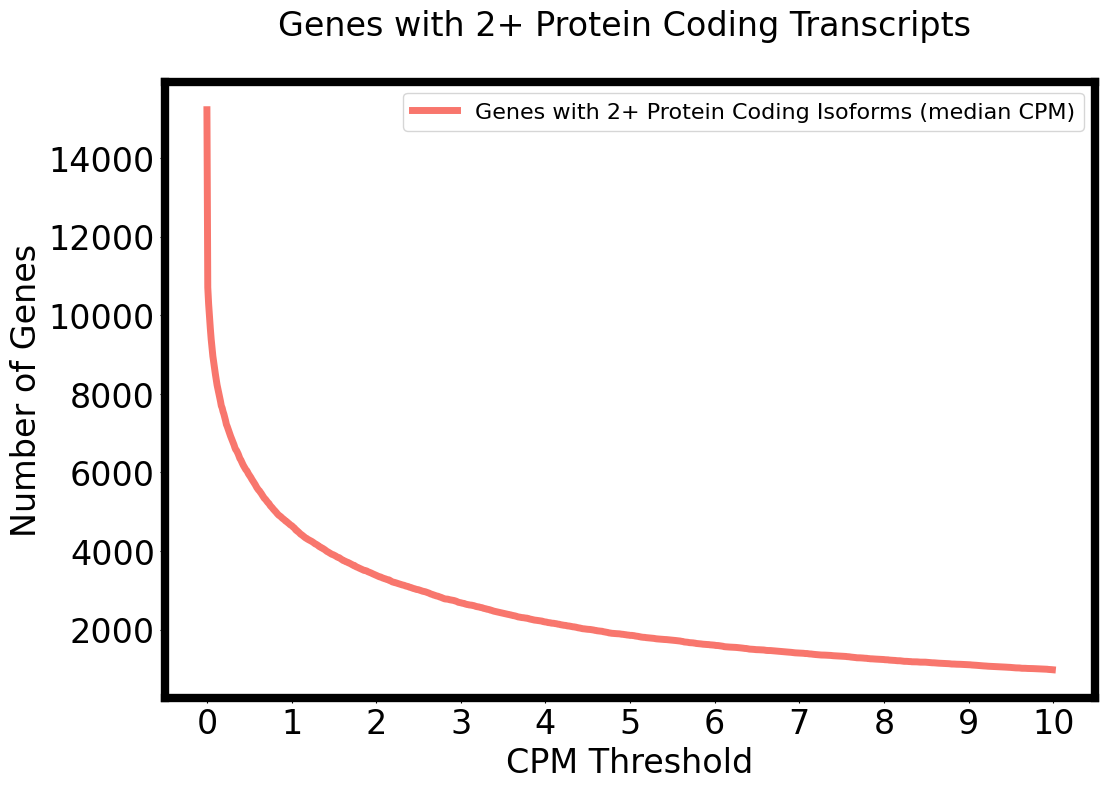

In [148]:
## Make plot showing number of protein coding genes with multiple expressed isoforms across CPM thresh

plt.plot(list_cpm_thresh, list_genes_multiple_prot_isoforms_median, color=ggplot2_colors[0], label="Genes with 2+ Protein Coding Isoforms (median CPM)", linewidth=5, alpha=1)


plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Genes')
plt.legend(loc="upper right", fontsize=16)
plt.title("Genes with 2+ Protein Coding Transcripts \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08B/number_genes_with_multiple_protein_coding_transcripts_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08B/number_genes_with_multiple_protein_coding_transcripts_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

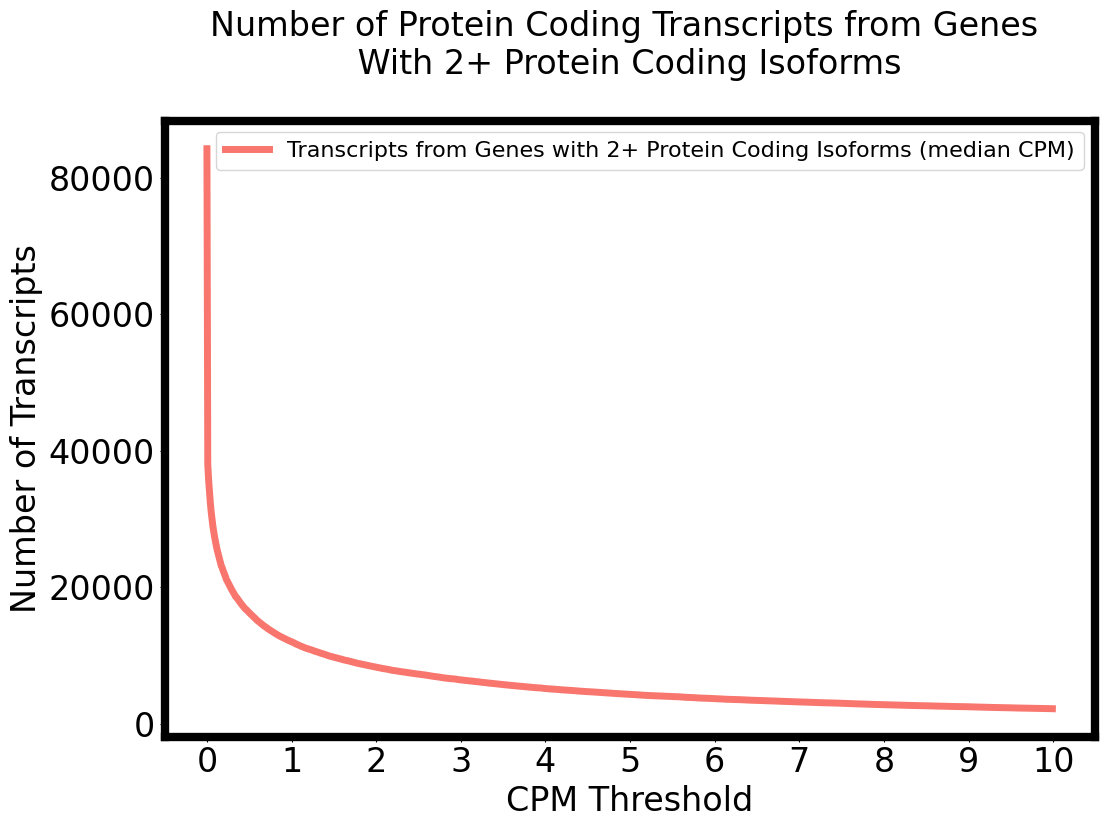

In [149]:
## Make plot showing number of protein coding genes with multiple expressed isoforms across CPM thresh

plt.plot(list_cpm_thresh, list_prot_multiple_isoforms_median, color=ggplot2_colors[0], label="Transcripts from Genes with 2+ Protein Coding Isoforms (median CPM)", linewidth=5, alpha=1)


plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Number of Protein Coding Transcripts from Genes \n With 2+ Protein Coding Isoforms \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08B/number_of_protein_coding_genes_from_genes_expressing_multiple_across_cpm_thresh.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08B/number_of_protein_coding_genes_from_genes_expressing_multiple_across_cpm_thresh.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

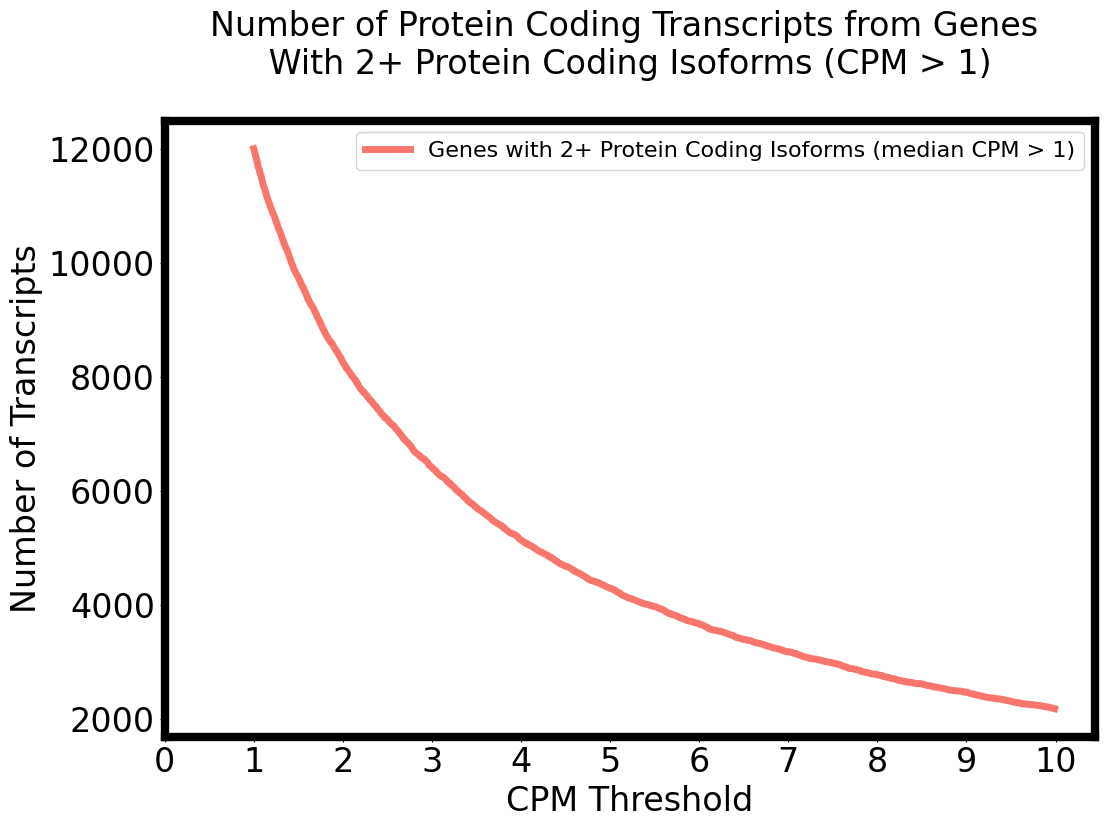

In [150]:
## Make plot showing number of protein coding genes with multiple expressed isoforms across CPM thresh

plt.plot(list_cpm_thresh[100:], list_prot_multiple_isoforms_median[100:], color=ggplot2_colors[0], label="Genes with 2+ Protein Coding Isoforms (median CPM > 1)", linewidth=5, alpha=1)

plt.xticks(np.arange(0, 11, 1))
plt.xlabel('CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=16)
plt.title("Number of Protein Coding Transcripts from Genes \n With 2+ Protein Coding Isoforms (CPM > 1) \n", fontsize=24)


plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08B/number_of_protein_coding_genes_with_multiple_protein_coding_isoforms_across_cpm_thresh_cpm_above_1.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08B/number_of_protein_coding_genes_with_multiple_protein_coding_isoforms_across_cpm_thresh_cpm_above_1.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()

In [152]:
## Create CPM 5 Threhold multiple isoform filter

df_prot_median_multiple_iso = protein_count.loc[protein_count["median_CPM"] >= cpm_thresh].copy()

df_prot_median_multiple_iso = df_prot_median_multiple_iso.loc[df_prot_median_multiple_iso.duplicated(subset="gene_id", keep=False)]

## Get number of genes with multiple isoforms
df_numbers_prot_multiple_isoforms_median = df_prot_median_multiple_iso["gene_id"].value_counts()


In [153]:
## Get numbers of genes with multiple CPM > 5 protein coding isoforms for both filters

df_num_isoforms_prot_median = pd.DataFrame()
df_num_isoforms_prot_median["Number of Genes"] = df_numbers_prot_multiple_isoforms_median.value_counts()
df_num_isoforms_prot_median["Number of Protein Coding Isoforms"] = df_numbers_prot_multiple_isoforms_median.value_counts().index

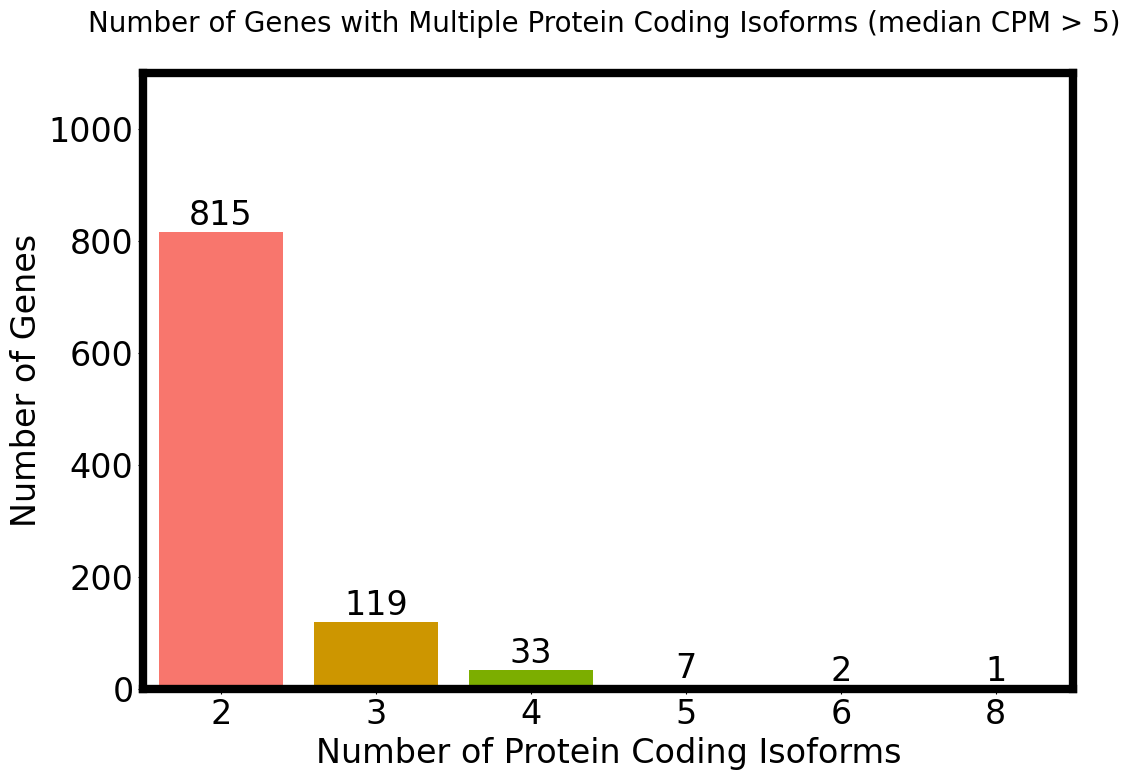

In [154]:
## Create and save graph showing number of genes with multiple protein coding isoforms (median CPM > 5)

ax = sns.barplot(data=df_num_isoforms_prot_median, y="Number of Genes", x="Number of Protein Coding Isoforms",
            palette=ggplot2_colors, saturation=1)

ax.bar_label(ax.containers[0])
plt.title("Number of Genes with Multiple Protein Coding Isoforms (median CPM > 5) \n", fontsize=20)
ax.set(ylim=(0, 1100))

plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08B/genes_with_multiple_protein_coding_transcripts_median_cpm_5.png', dpi=300, transparent=True, bbox_inches="tight")
plt.savefig('../../../figures/bernardo/03.gene_and_transcripts_descriptive_stats/summary_stats_genes_and_transcripts_MEDIAN/08B/genes_with_multiple_protein_coding_transcripts_median_cpm_5.svg', dpi=300, transparent=True, bbox_inches="tight")

plt.show()